In [105]:
import pandas as pd
import glob
import pyreadstat as py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve

*data set import and features selection*

In [2]:
#Import
paths = 'FSMS\work_modele\*'
glob.glob(paths)
date = ['29-12-2013','20-01-2016', '03-06-2015','31-05-2015','26-06-2014', '01-07-2013']
data = []
i = 0
for path in glob.glob(paths):
    df,_ = py.read_sav(path, encoding="ISO-8859-1")
    df['date'] = date[i]
    df.date=pd.to_datetime(df.date)
    print(f"import dataframe {i}---> OK")
    data.append(df)
    i +=1
frame = []
for i in range(len(data)):
    mask = (data[i]['Q4_1'] != 0) | (data[i]['Q4_2'] != 0) | (data[i]['Q4_3'] != 0) | (data[i]['Q4_4'] != 0)
    frame.append(data[i][mask])
for i in range(len(frame)):
    frame[i].reset_index(drop=True, inplace=True)

import dataframe 0---> OK
import dataframe 1---> OK
import dataframe 2---> OK
import dataframe 3---> OK
import dataframe 4---> OK
import dataframe 5---> OK


In [3]:
# rename
for i in range(len(frame)):
    frame[i].rename(columns={'MOUGHATAA': 'moughataa'}, inplace=True)
for i in range(len(frame)):
    column_list = frame[i].columns.to_list()
    if 'CODREG' in column_list:
        frame[i].rename(columns={'CODREG': 'wilaya'}, inplace=True)
    elif 'WILAYA' in column_list:  
        frame[i].rename(columns={'WILAYA': 'wilaya'}, inplace=True)

C:\Users\froge\.conda\envs\analyse\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [32]:
# frame[1].columns.to_list()

In [4]:
df = pd.concat(frame)

*target checking* 

In [5]:
df['IA'] = df['FCS'].apply(lambda x: 1 if x < 42 else 0)

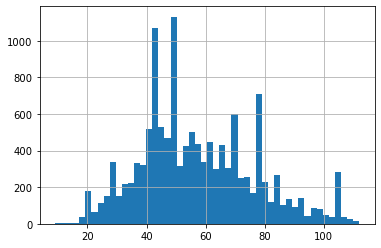

moyenne des FCS : 57.15841622035195
median des FCS : 54.0


In [12]:
df['FCS'].hist(bins=50)
plt.show()
print("moyenne des FCS :", df['FCS'].mean())
print("median des FCS :", df['FCS'].median())

In [14]:
df['IA'].value_counts(normalize=True)

0    0.796741
1    0.203259
Name: IA, dtype: float64

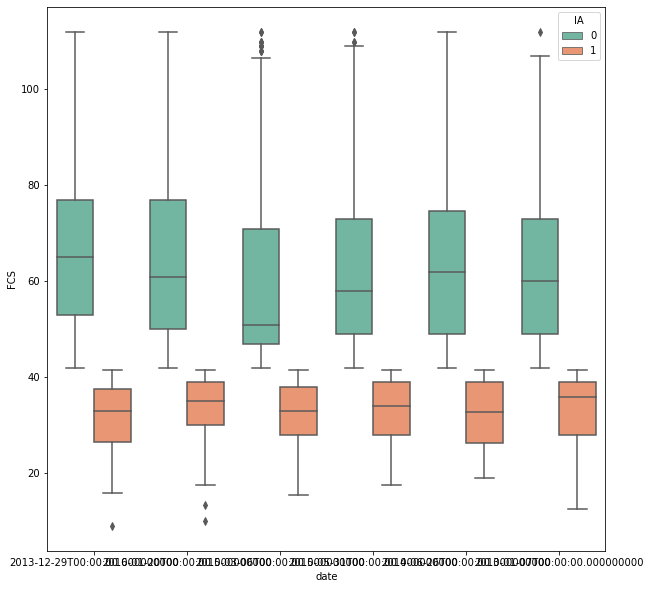

In [36]:
plt.figure(figsize=(10,10))
sns.boxplot(y=df['FCS'], x=df['date'], hue=df['IA'], palette="Set2")
plt.show()

*dataset checking*

*NA checking*

<AxesSubplot:>

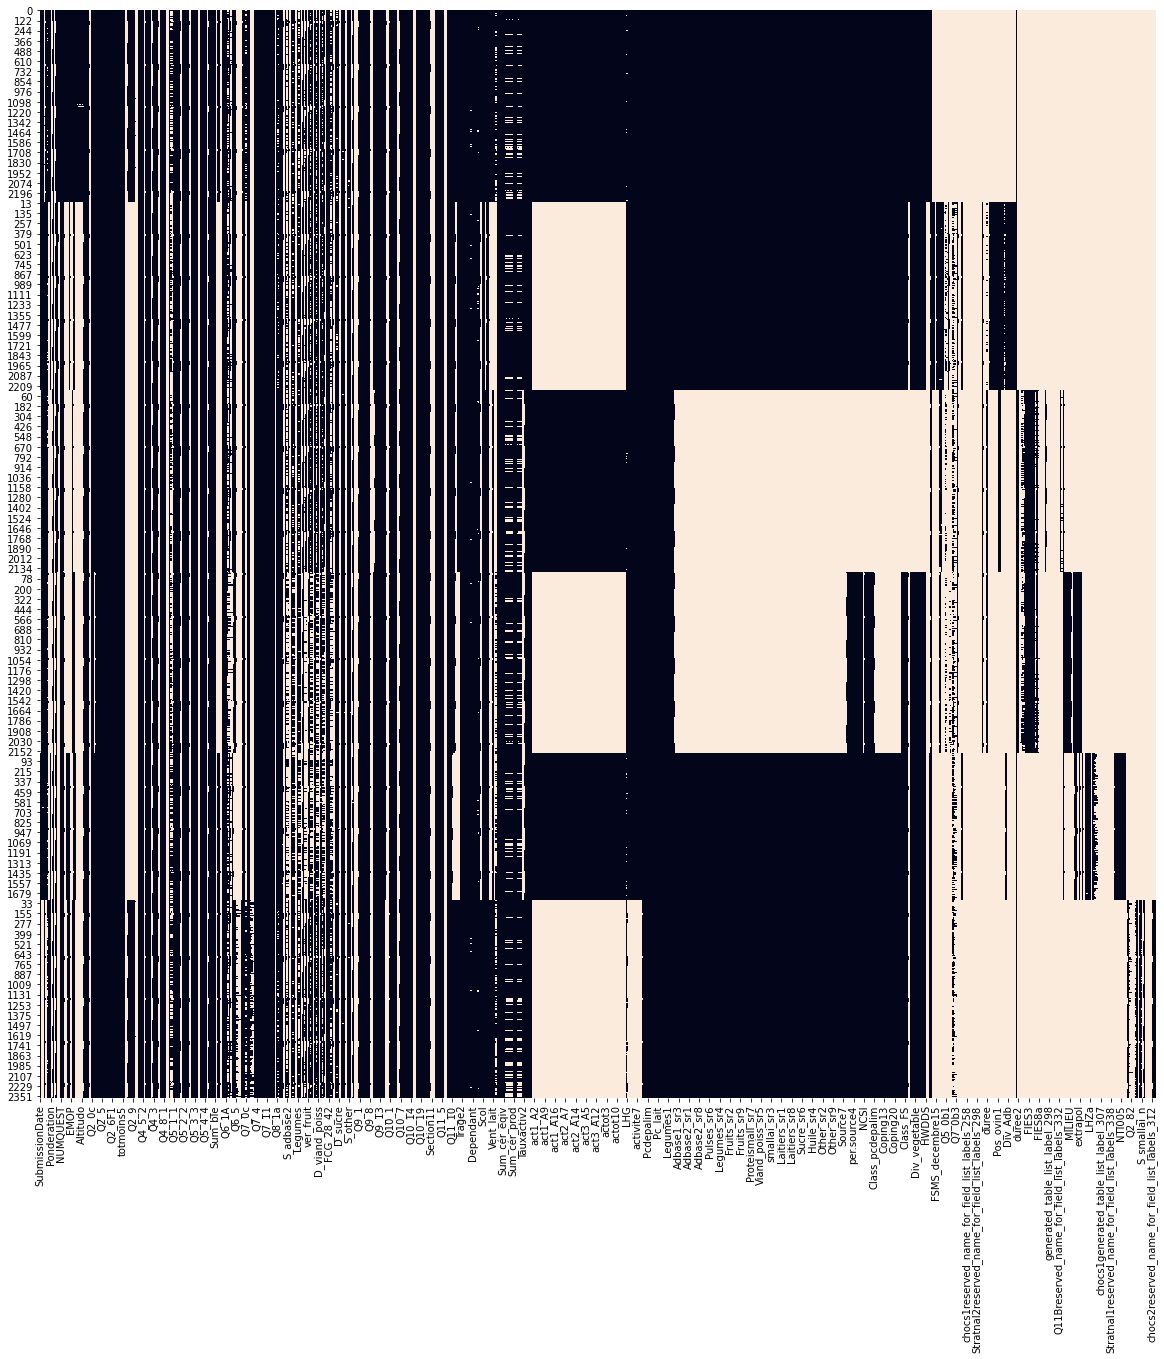

In [36]:
plt.figure(figsize=(20,20))
sns.heatmap(df.isna(), cbar=False)

Drop NA > 90%

In [40]:
df_modele = df[df.columns[(df.isna().sum()/df.shape[0]*100) < 0.90]]
df_modele.head()

accord  CODEKIP  NUMQUEST  wilaya  moughataa       Latitude      Longitude  \
0     1.0      1.0  112110.0     1.0       14.0  16.2074289132  -7.1780668959   
1     1.0      1.0  112604.0     1.0       16.0  15.6456900291  -7.9994373632   
2     1.0      1.0  112102.0     1.0       14.0  16.2083739005  -7.1786701327   
3     1.0      1.0  112715.0     1.0       16.0  15.7545087066  -8.2644169745   
4     1.0      1.0  111905.0     1.0       13.0  16.1641167927  -8.8703254462   

         Altitude      Accuracy  Q2_0c  ...  AdBase  Legumineuse  Fruits1  \
0  284.1474410174  4.0000000000   10.0  ...     7.0          3.0      0.0   
1  326.6478107334  4.0000000000    4.0  ...     7.0          5.0      0.0   
2  283.8503915348  4.0000000000    2.0  ...     7.0          2.0      0.0   
3  260.4096180228  4.0000000000   15.0  ...     7.0          3.0      0.0   
4  217.1792293902  4.0000000000    5.0  ...     7.0          7.0      0.0   

   Legumes1  Viande_poisson  Lait  Huile1  Sucre1       date  IA  
0       0.0             5.0   7.0     7.0     7.0 2013-12-29   0  
1       0.0             0.0   5.0     6.0     0.0 2013-12-29   0  
2       0.0             0.0   0.0     0.0     0.0 2013-12-29   1  
3       0.0             0.0   0.0     7.0     0.0 2013-12-29   1  
4       7.0             0.0   0.0     7.0     7.0 2013-12-29   0  

[5 rows x 221 columns]

first columns selection

In [41]:
drop_list = ["accord", "CODEKIP", "NUMQUEST", "wilaya", "moughataa","Q5_0a","Q5_1_1","Q5_1_2","Q5_1_2","Q5_1_3","Q5_1_4","Sum_mil","Q5_2_1","Q5_2_2","Q5_2_3","Q5_2_4",
             "Sum_sorg","Q5_3_1","Q5_3_2","Q5_3_3","Q5_3_4","Sum_mais","Q5_4_1","Q5_4_2","Q5_4_3","Q5_4_4","Sum_riz","Q5_5_1","Q5_5_2","Q5_5_3","Q5_5_4","Sum_ble",
            "Adbase1", "S_adbase1","D_adbase1","Adbase2","Pulses","Legumes","Fruits","Proteismall","Viand_poiss","smallai","FCS","FCG_28_42","Laitiers","Sucre","D_sucre","Huile","S_huile","D_huile","Other","D_other","Q8_20",
            "Pc_cer","Pc_pulses","Pc_légumes","Pc_fruit","Pc_protein","Pc_lait","Pc_sucre","Pc_huile","Pc_other","AdBase","Legumineuse","Fruits1","Legumes1","Viande_poisson","Lait","Huile1","Sucre1","date"]              
df_modele = df_modele.drop(drop_list, axis=1)

In [42]:
df_modele.head()

Latitude      Longitude        Altitude      Accuracy  Q2_0c  Q2_0a  \
0  16.2074289132  -7.1780668959  284.1474410174  4.0000000000   10.0    1.0   
1  15.6456900291  -7.9994373632  326.6478107334  4.0000000000    4.0    1.0   
2  16.2083739005  -7.1786701327  283.8503915348  4.0000000000    2.0    1.0   
3  15.7545087066  -8.2644169745  260.4096180228  4.0000000000   15.0    1.0   
4  16.1641167927  -8.8703254462  217.1792293902  4.0000000000    5.0    0.0   

   Q2_1  Q2_2  Q2_3  Q2_4  ...  revenu2  revenu3  revenu_mens   rev_percap  \
0  55.0   1.0   1.0   6.0  ...     33.0      0.0         66.0     4.258065   
1  67.0   2.0   3.0   6.0  ...      0.0      0.0       1000.0  1000.000000   
2  40.0   1.0   1.0   5.0  ...      0.0      0.0       6000.0  1500.000000   
3  38.0   2.0   3.0   6.0  ...   2000.0      0.0       8000.0  2000.000000   
4  45.0   1.0   1.0   6.0  ...   8000.0      0.0       8025.0  1146.428571   

       DepNalim  Depalim        Deptot   Pcdepalim  PcdepNalim  IA  
0      0.000000  58600.0  58600.000000  100.000000    0.000000   0  
1    833.333333   9000.0   9833.333333   91.525424    8.474576   0  
2  24000.000000  12600.0  36600.000000   34.426230   65.573770   1  
3    166.666667  13600.0  13766.666667   98.789346    1.210654   1  
4  21833.333333  42500.0  64333.333333   66.062176   33.937824   0  

[5 rows x 151 columns]

*checking type and retyping*

In [43]:
df_modele.dtypes

Latitude       object
Longitude      object
Altitude       object
Accuracy       object
Q2_0c         float64
               ...   
Depalim       float64
Deptot        float64
Pcdepalim     float64
PcdepNalim    float64
IA              int64
Length: 151, dtype: object

In [44]:
df_modele.Latitude = df_modele.Latitude.astype(float)
df_modele.Altitude = df_modele.Altitude.astype(float)
df_modele.Longitude = df_modele.Longitude.astype(float)

*feature selection*

In [45]:
df_modele.isna().sum()

Latitude      0
Longitude     0
Altitude      0
Accuracy      0
Q2_0c         0
             ..
Depalim       0
Deptot        1
Pcdepalim     1
PcdepNalim    1
IA            0
Length: 151, dtype: int64

In [46]:
df_modele = df_modele.dropna().copy()

*creation of selection categorie*

In [47]:
df_IA_one = df_modele[df_modele['IA'] == 1]
df_IA_zero = df_modele[df_modele['IA'] == 0]
cattle_col = df[['Q4_1','Q4_2','Q4_3','Q4_4','Q4_5_1','Q4_5_2','Q4_6_1','Q4_6_2','Q4_7_1','Q4_7_2','Q4_8_1', 'Q4_8_2']]
geo = df_modele[['Latitude', 'Longitude', 'Altitude']]
Q2 = df_modele[['Q2_0c','Q2_0a','Q2_1','Q2_2','Q2_3','Q2_4','Q2_5','Q2_6M1','Q2_6M2','Q2_6M3','Q2_6M4','Q2_6M5','Q2_6M6','Q2_6F1','Q2_6F2','Q2_6F3','Q2_6F4','Q2_6F5','Q2_6F6']]
Q6 = df_modele[['Q6_0A','Q6_0B','Q6_1A','Q6_1B']]
Q7 = df_modele[['Q7_0a','Q7_1','Q7_3','Q7_4','Q7_5','Q7_6','Q7_7','Q7_8','Q7_9','Q7_10','Q7_11','Q7_12','Q7_13','Q7_14','Q7_15','Q7_16']]
Q9 = df_modele[['Q9_1','Q9_2','Q9_3','Q9_4','Q9_5','Q9_6','Q9_7','Q9_8','Q9_10','Q9_11','Q9_12','Q9_13','Q9_14','Q9_15','Q9_16']]
Q10 = df_modele[["Q10_1","Q10_2","Q10_3","Q10_4","Q10_5","Q10_7","Q10_8","Q10_9","Q10_10","Q10_11","Q10_12","Q10_13","Q10_14","Q10_15","Q10_16","Q10_17","Q10_18","Q10_19","Q10_20","Q10_21","Q10_22","Q10_23","Q10_24"]]
Q11 = df_modele[["Q11_1","Q11_2","Q11_3","Q11_4","Q11_5","Q11_6","Q11_7","Q11_8","Q11_9","Q11_10","CSI_brut"]]
other = df_modele[['Trage1','Trage2','Tailmenag','Moins5','Nb_hom','Nb_fem','Pc_fem','Dependant','Actifs','Plusde15ans','TxDep1','Equiv_ad','Scol']]
pos = df_modele[["Pos_bovin","Pos_caprin","Pos_camelin"]]
sumd = df_modele[["Sum_céréales","Dispo_cer","Sum_cér_parper","Dispo_cer_parper","Sum_cér_eqiv","Dispo_cer_eqiv","Sum_cér_prod","Sum_cér_achat","Sum_cér_don"]]
revenu = df_modele[["revenu1","revenu2","revenu3","revenu_mens","rev_percap","DepNalim","Depalim","Deptot","Pcdepalim","PcdepNalim"]]

*check target/categorie*

C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

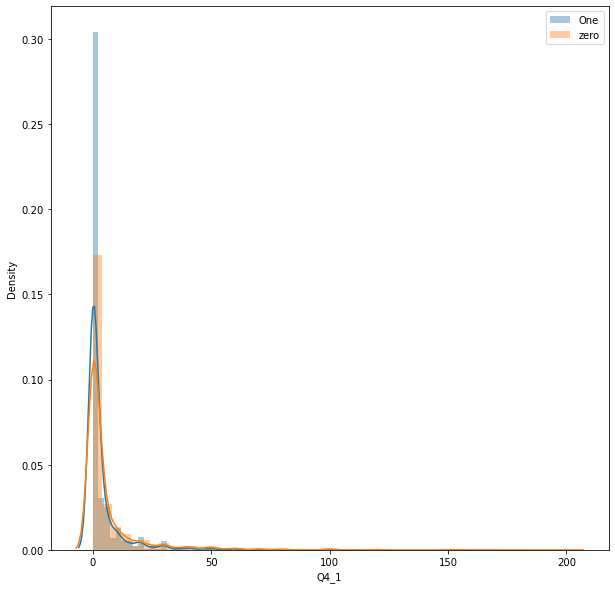

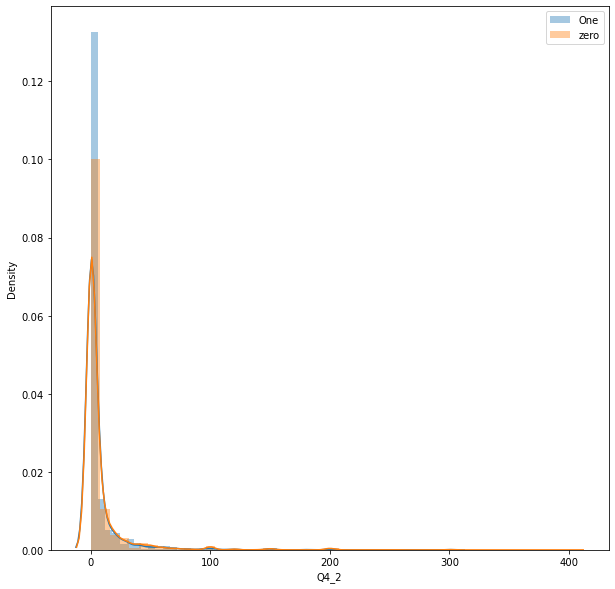

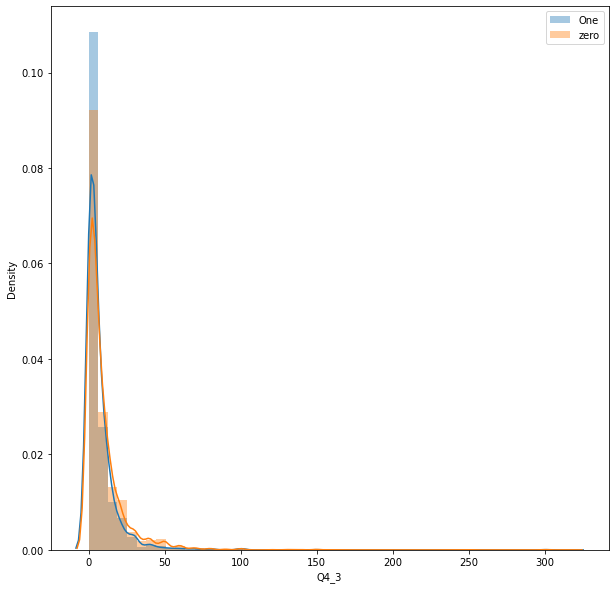

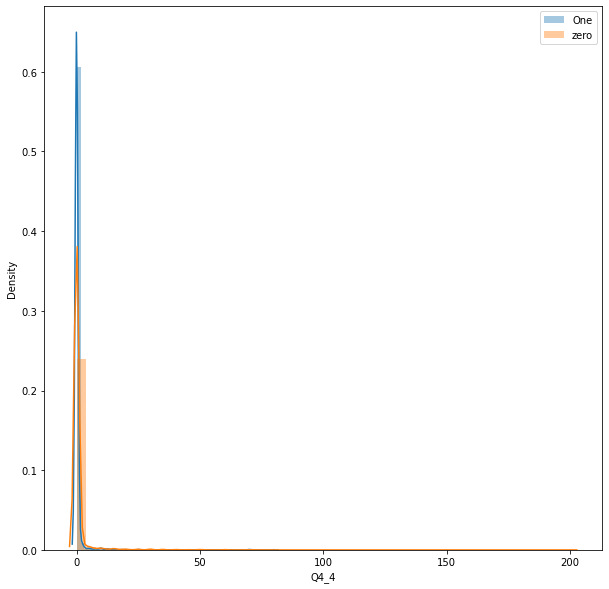

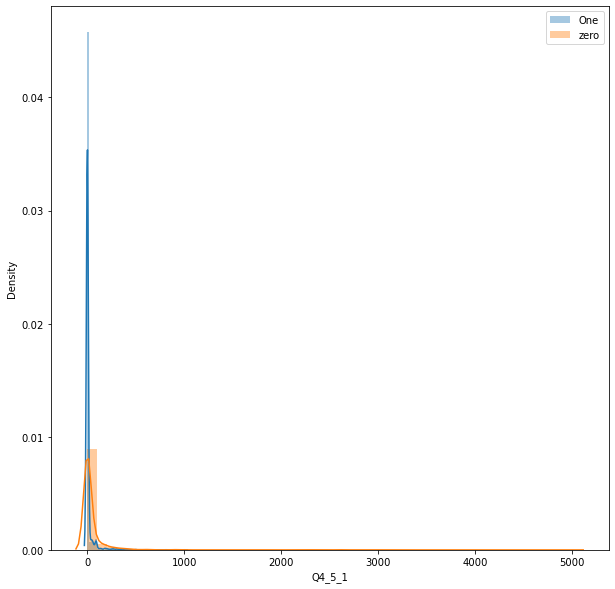

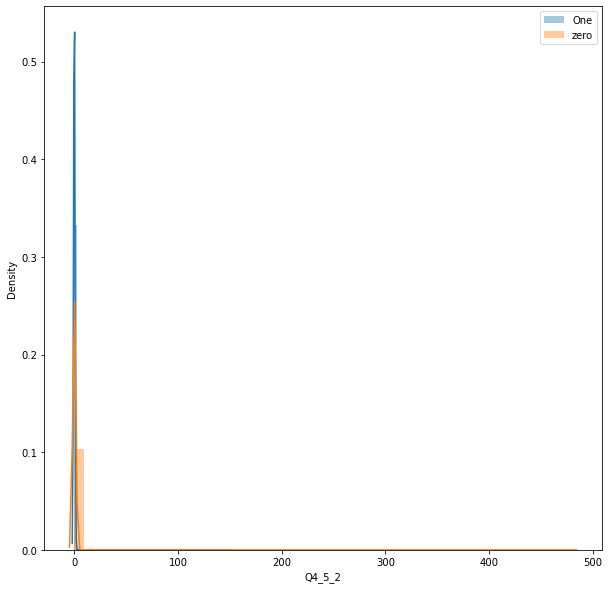

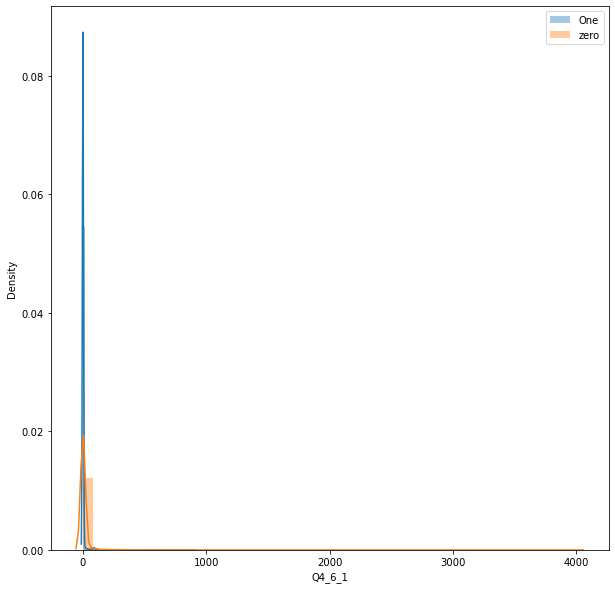

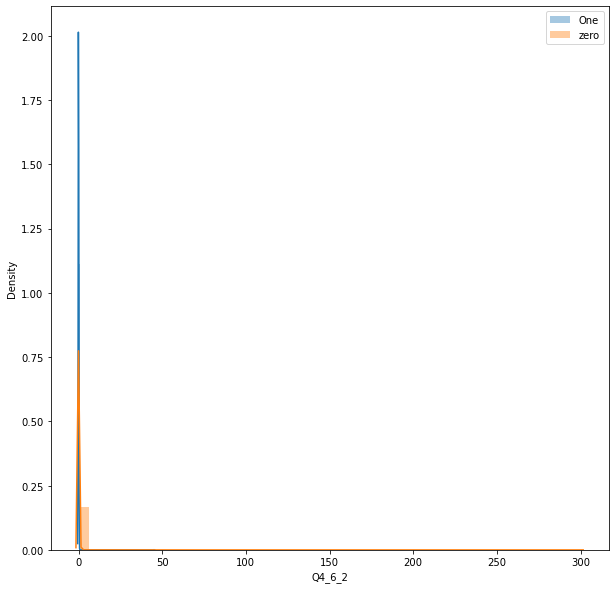

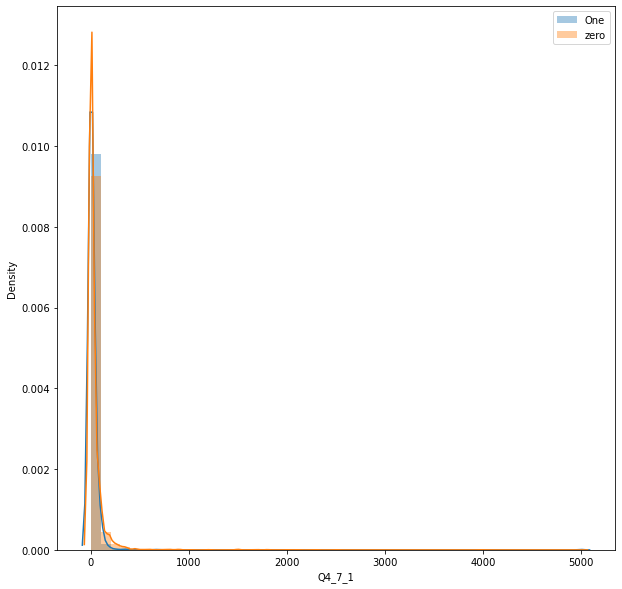

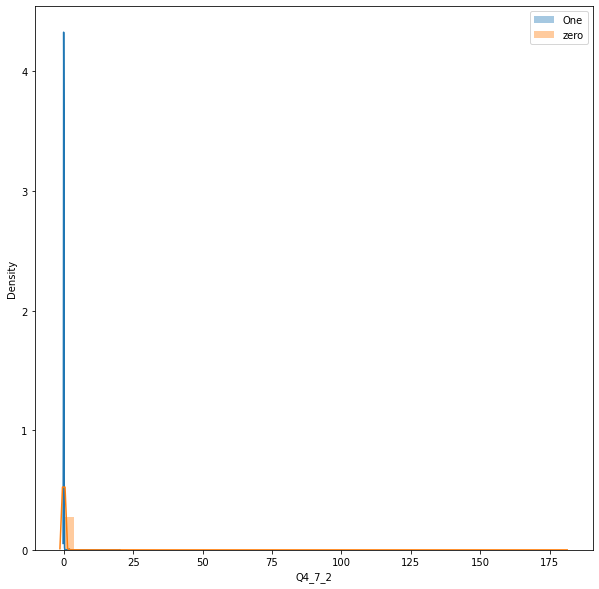

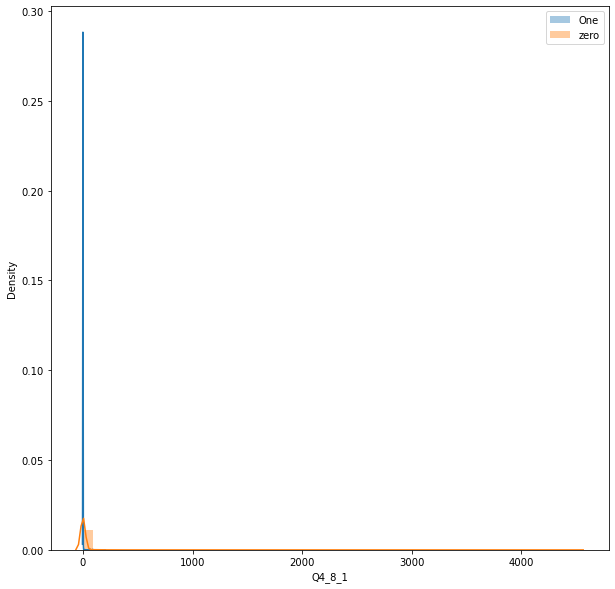

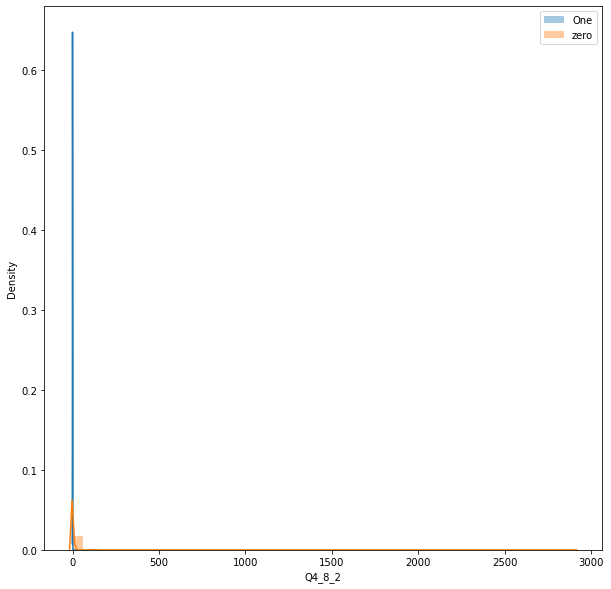

In [109]:
for col in cattle_col:
    plt.figure(figsize=(10,10))
    sns.distplot(df_IA_one[col], label= 'One')
    sns.distplot(df_IA_zero[col], label= 'zero')
    plt.legend()

In [187]:
Q4 = ["Q4_5_1", "Q4_5_2", "Q4_6_1", "Q4_6_2", "Q4_7_1","Q4_7_2", "Q4_8_1", "Q4_8_2"]

C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

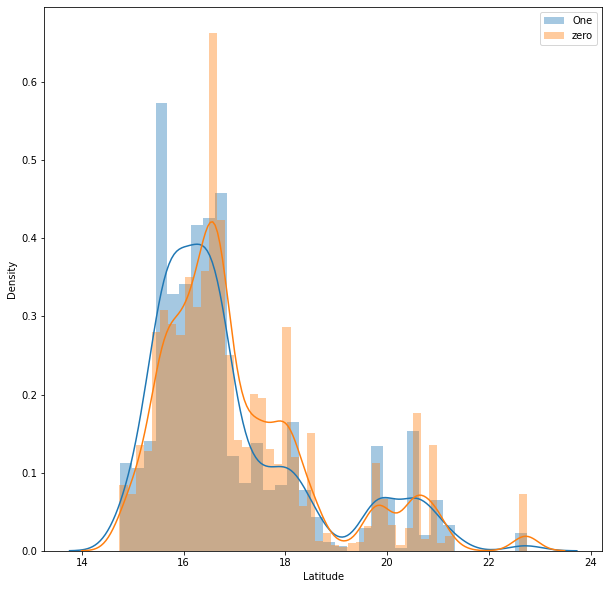

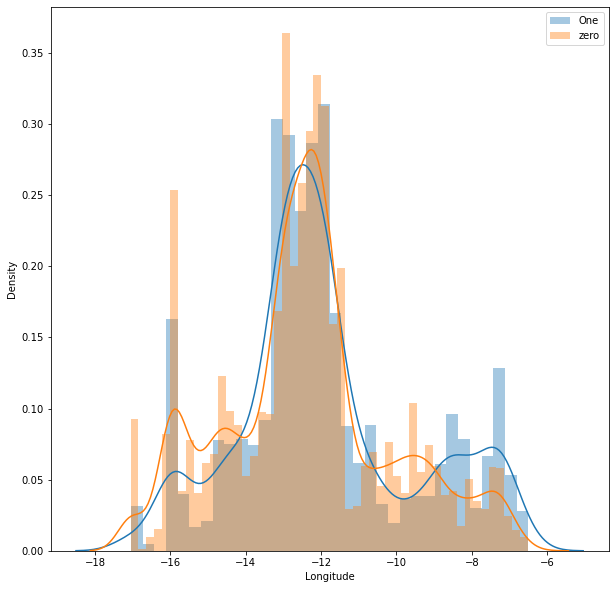

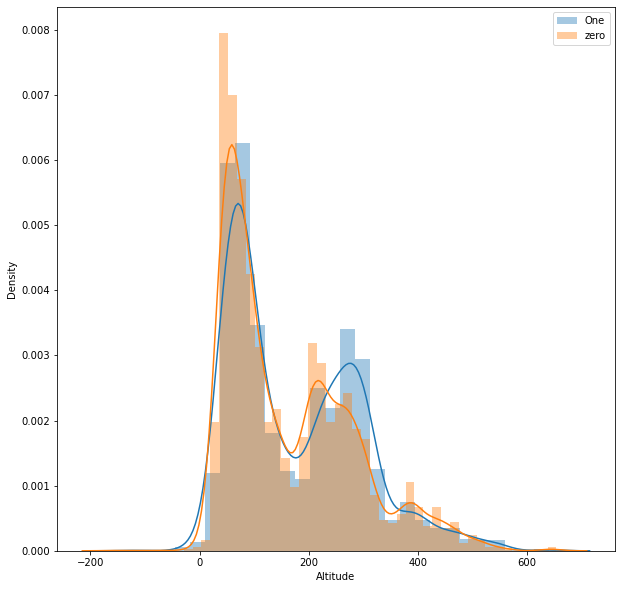

In [111]:
for col in geo:
    plt.figure(figsize=(10,10))
    sns.distplot(df_IA_one[col], label= 'One')
    sns.distplot(df_IA_zero[col], label= 'zero')
    plt.legend()

not selected

C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

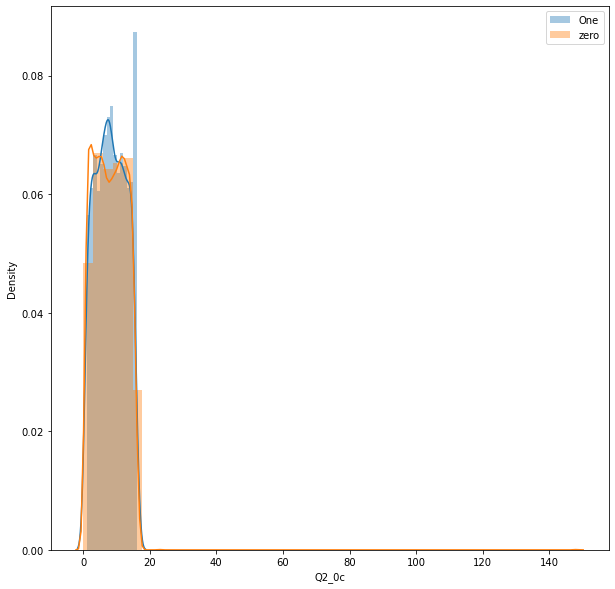

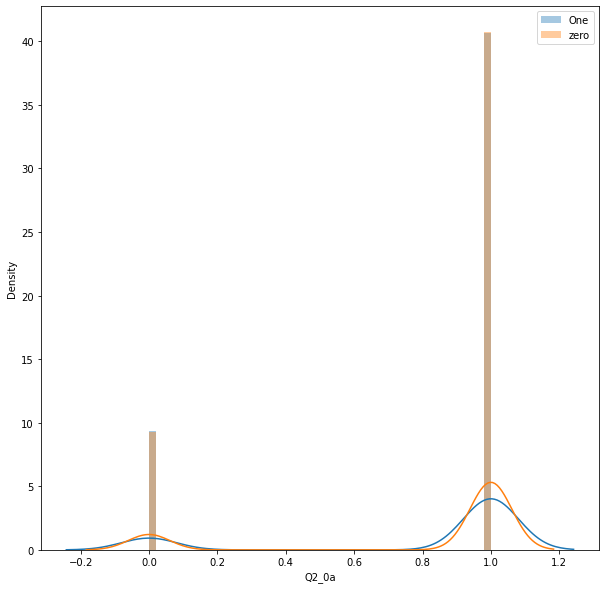

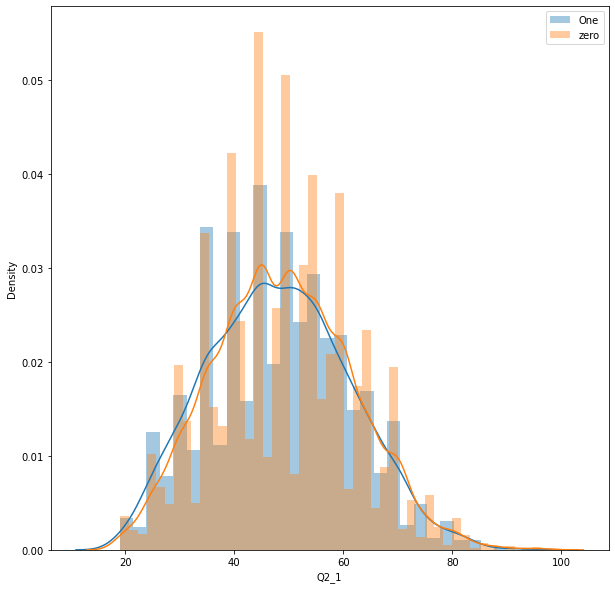

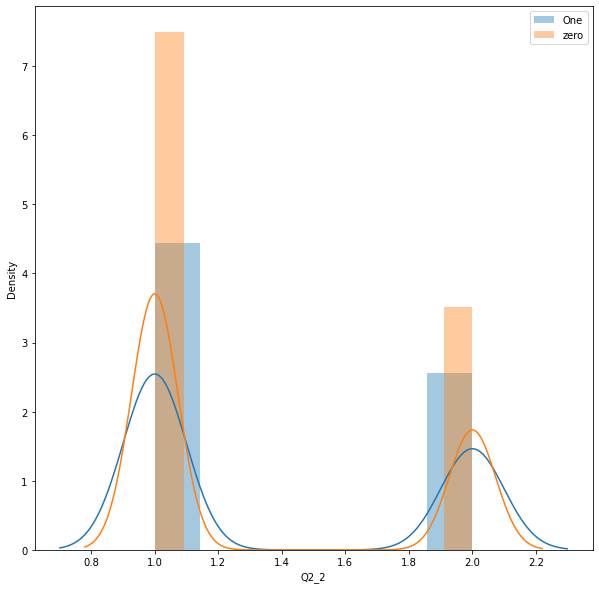

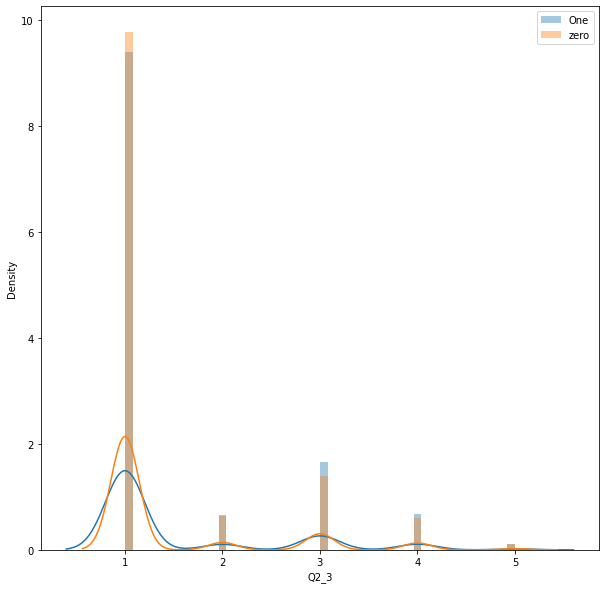

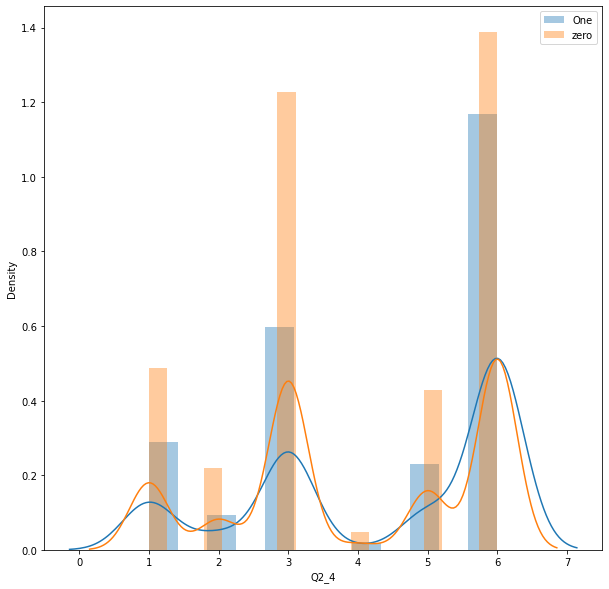

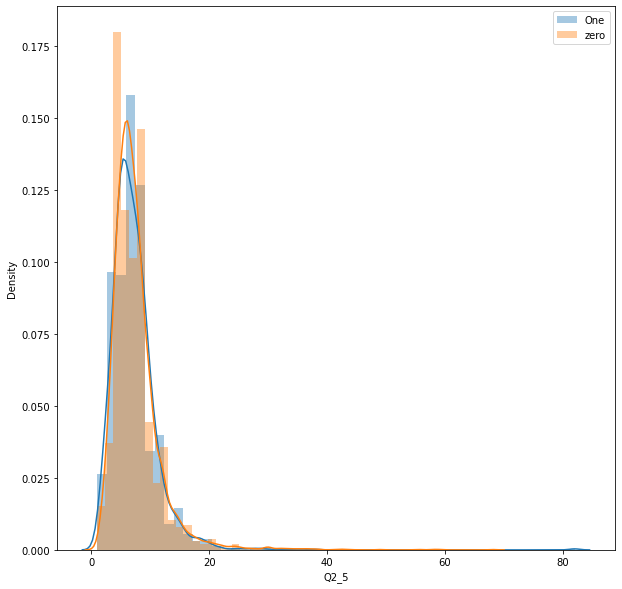

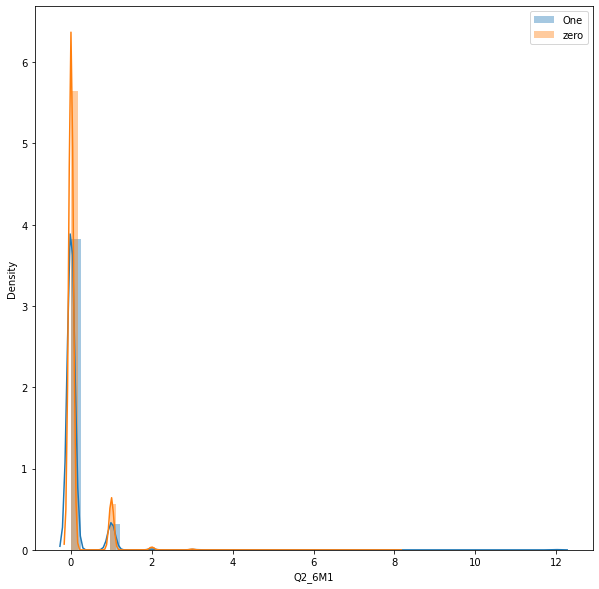

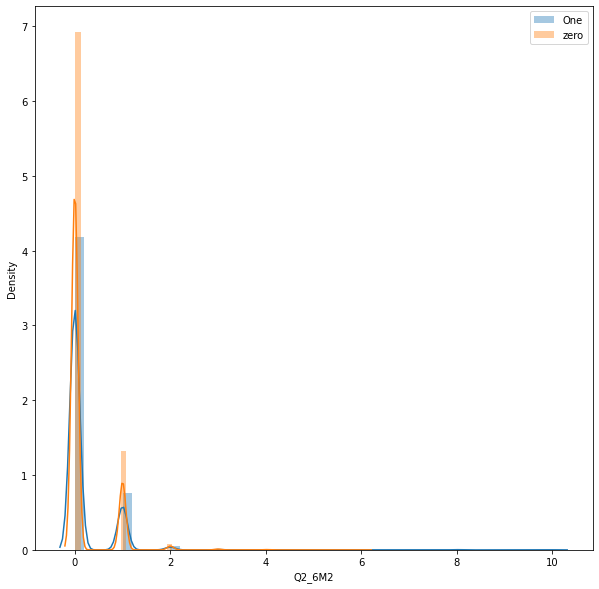

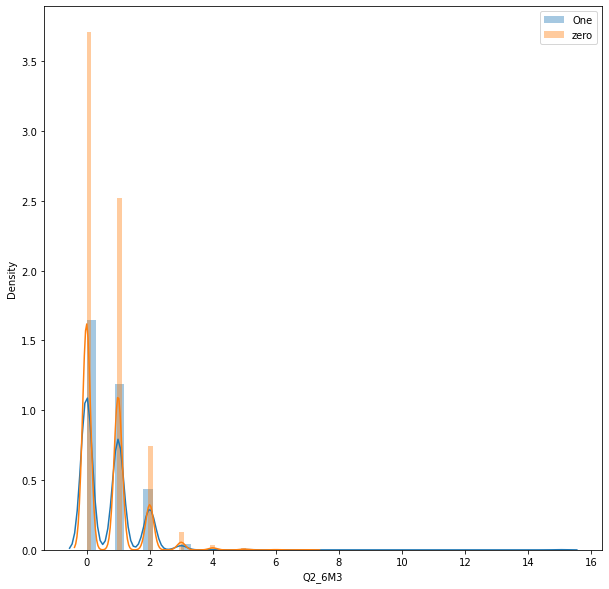

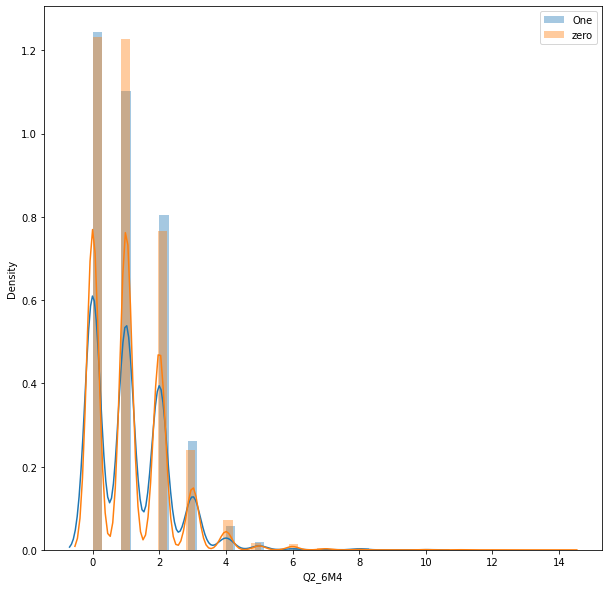

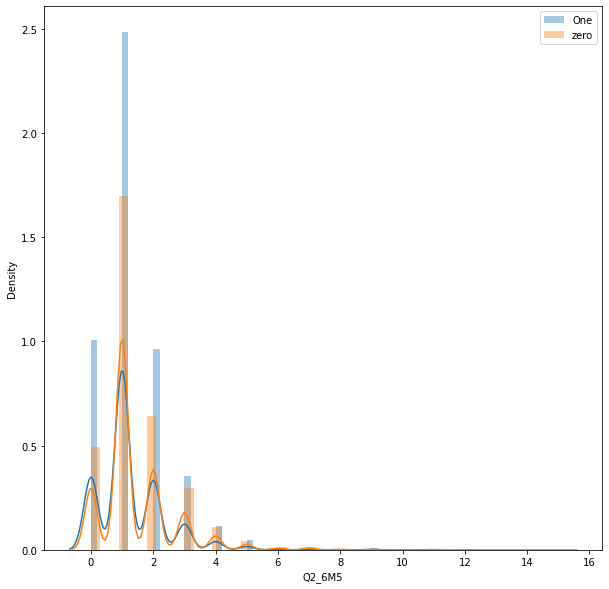

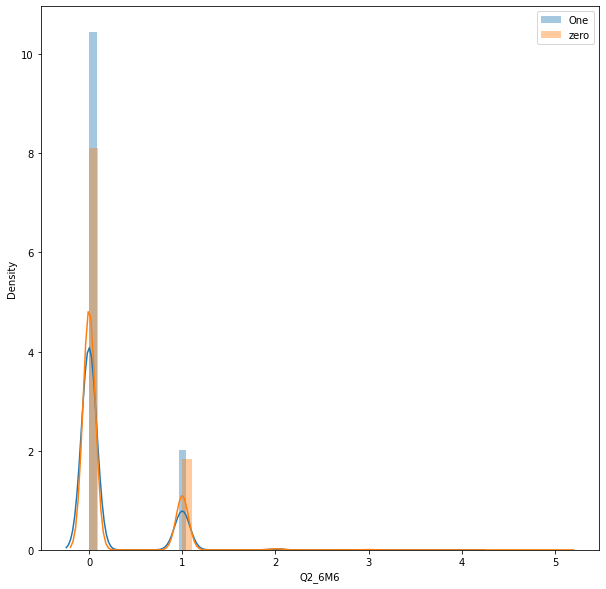

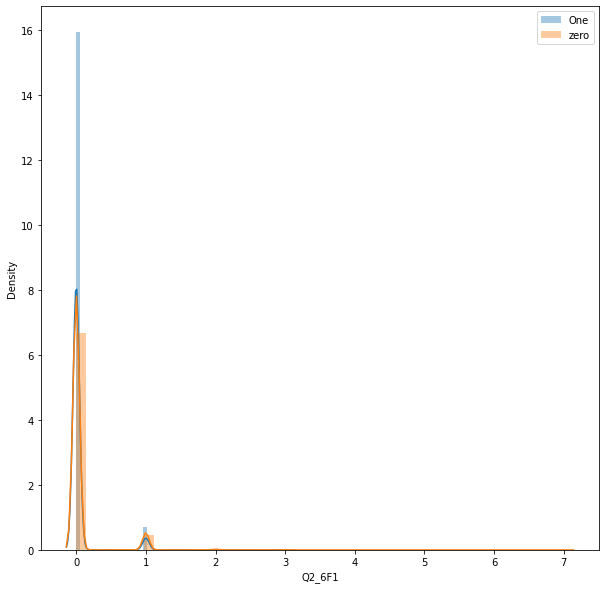

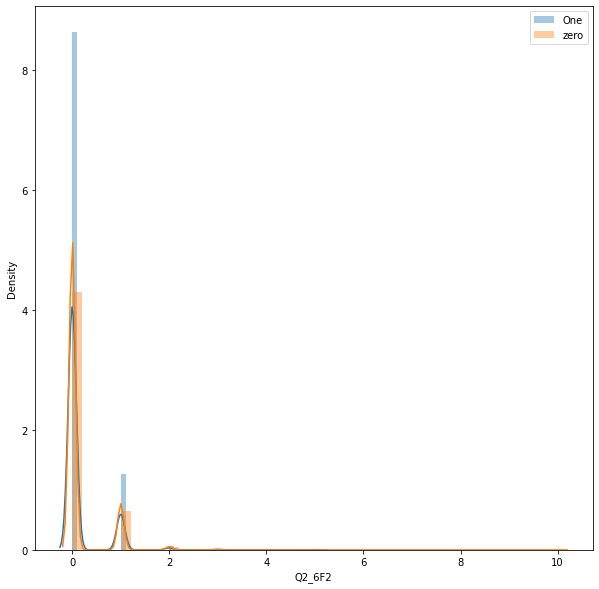

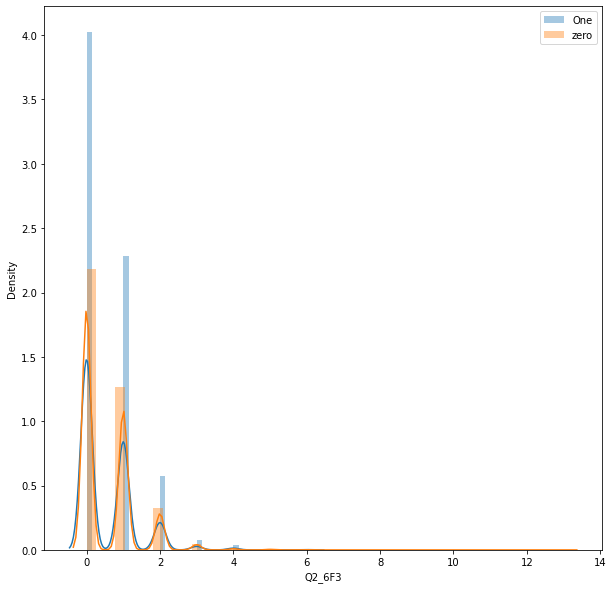

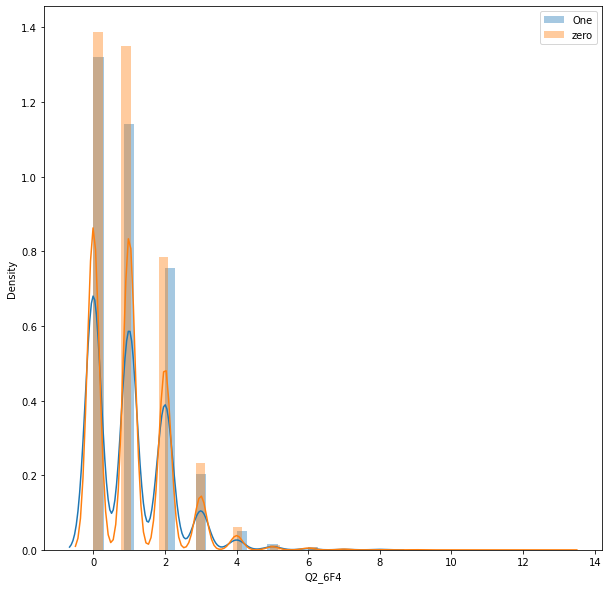

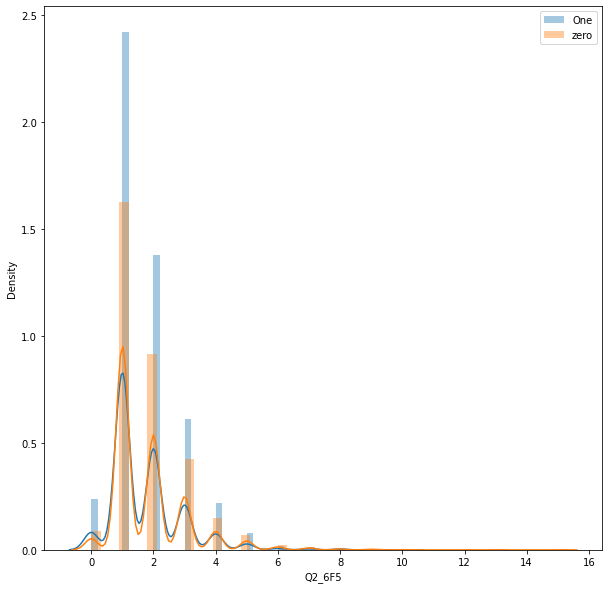

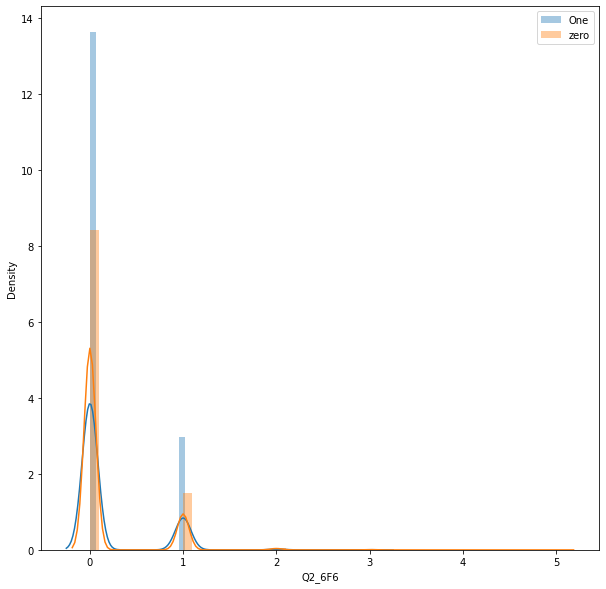

In [114]:
for col in Q2:
    plt.figure(figsize=(10,10))
    sns.distplot(df_IA_one[col], label= 'One')
    sns.distplot(df_IA_zero[col], label= 'zero')
    plt.legend()

In [183]:
Q2 = [ "Q2_2", "Q2_4", "Q2_6M1", "Q2_6M2", "Q2_6F4", "Q2_6F6"]

C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

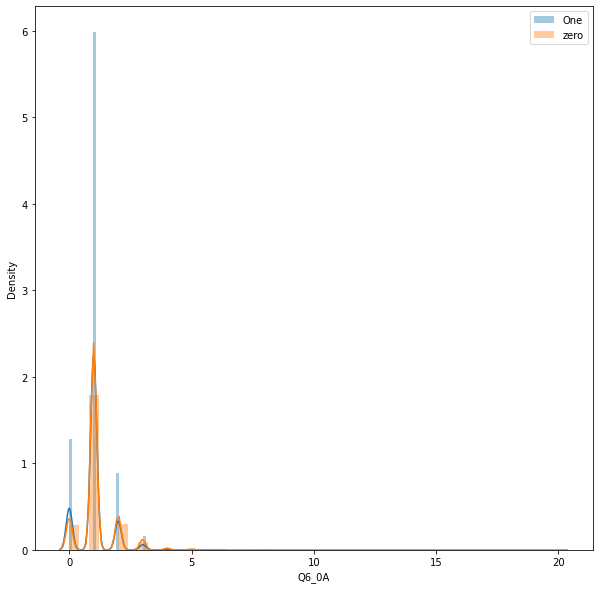

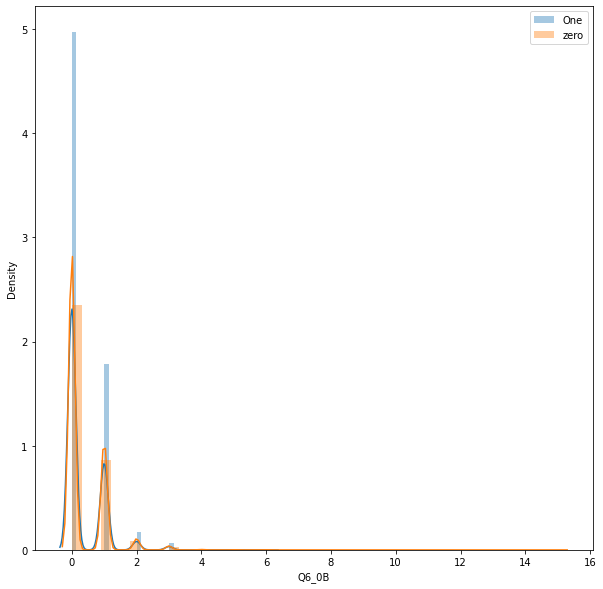

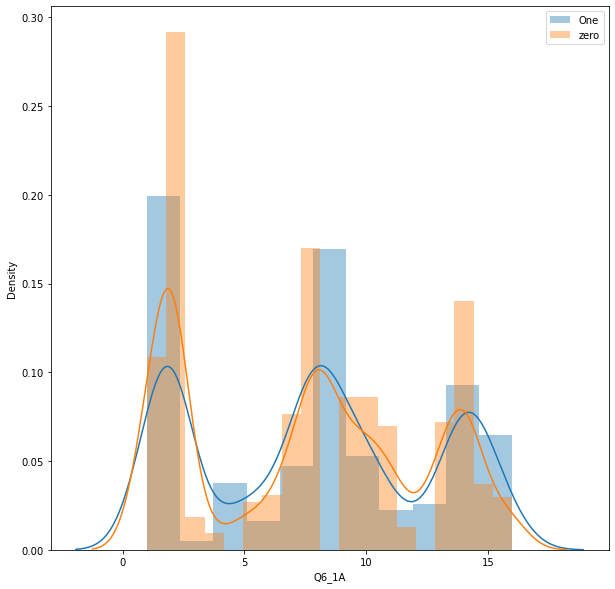

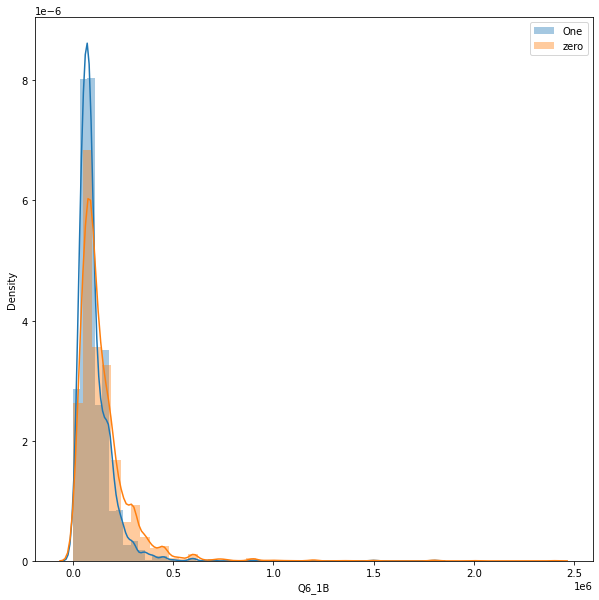

In [117]:
for col in Q6:
    plt.figure(figsize=(10,10))
    sns.distplot(df_IA_one[col], label= 'One')
    sns.distplot(df_IA_zero[col], label= 'zero')
    plt.legend()

In [191]:
Q6 = ["Q6_1A"]

C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

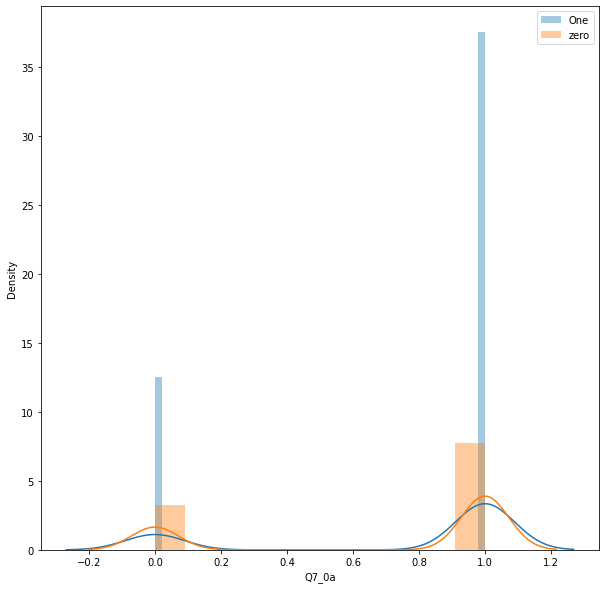

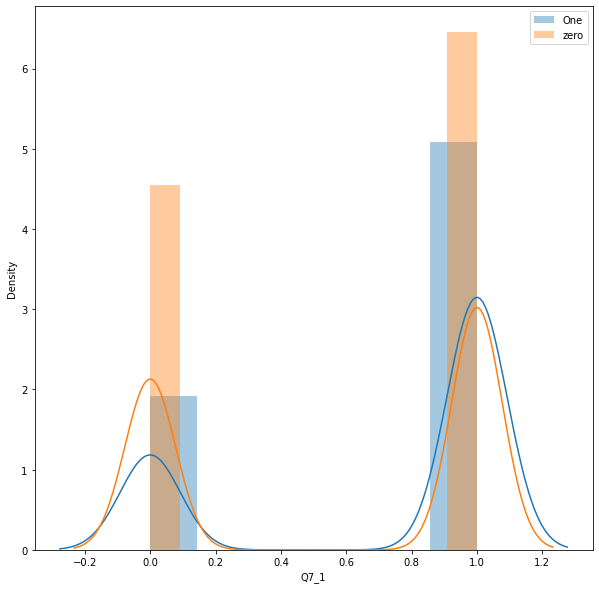

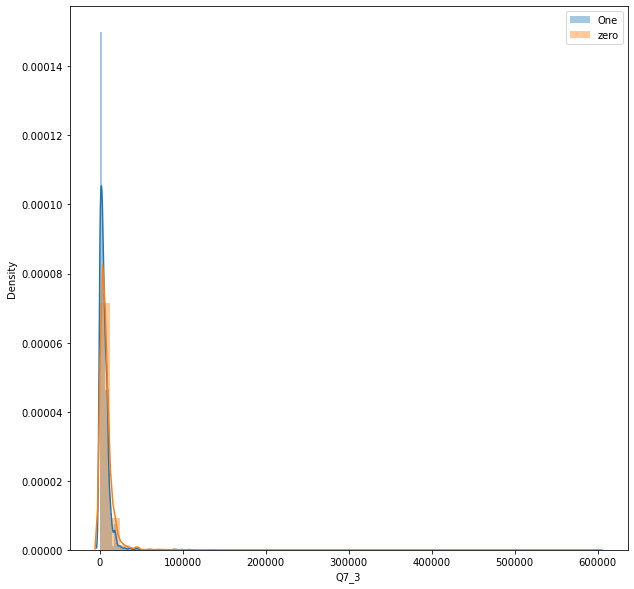

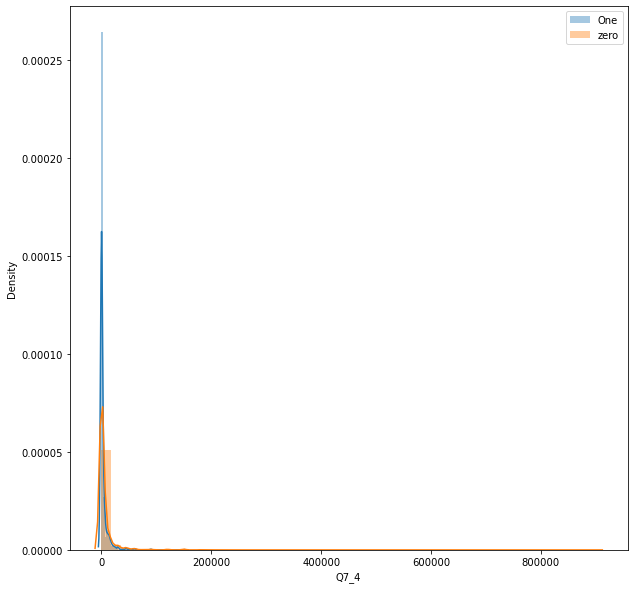

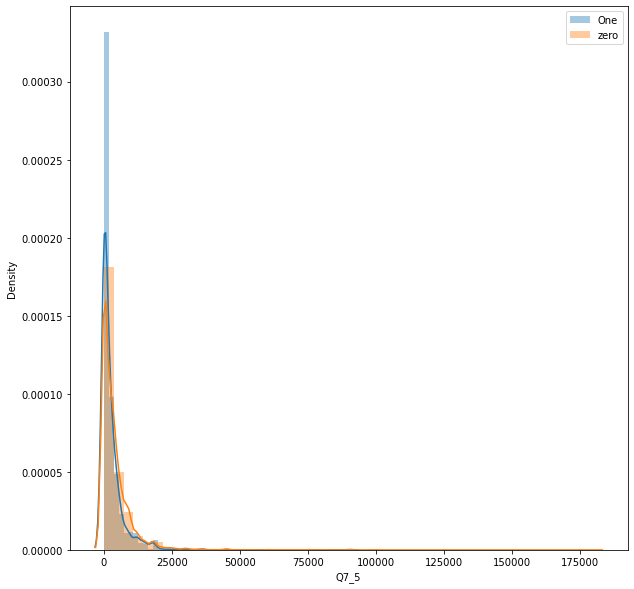

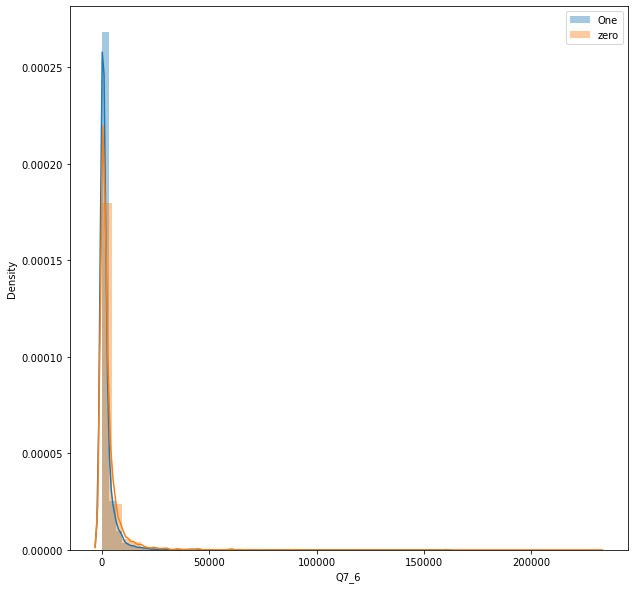

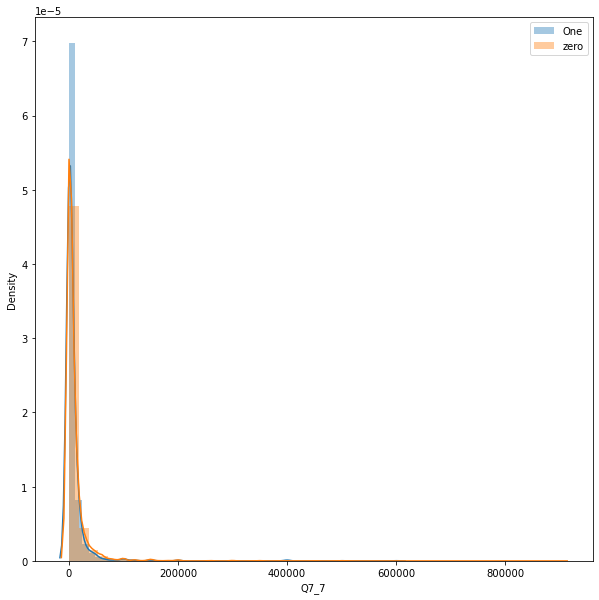

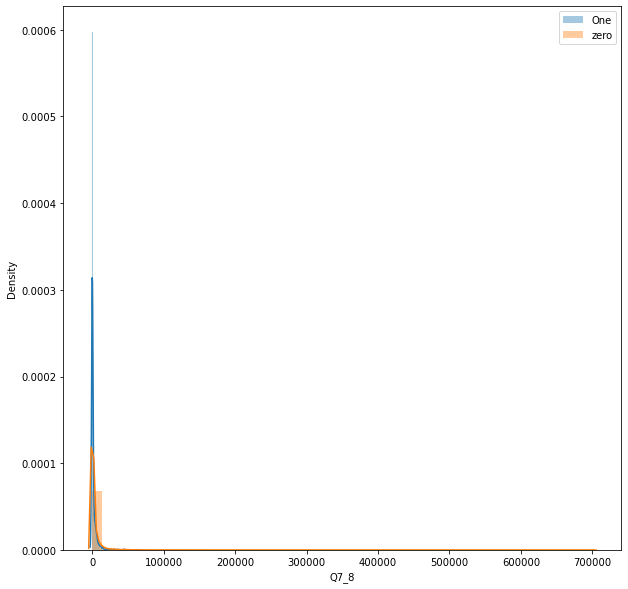

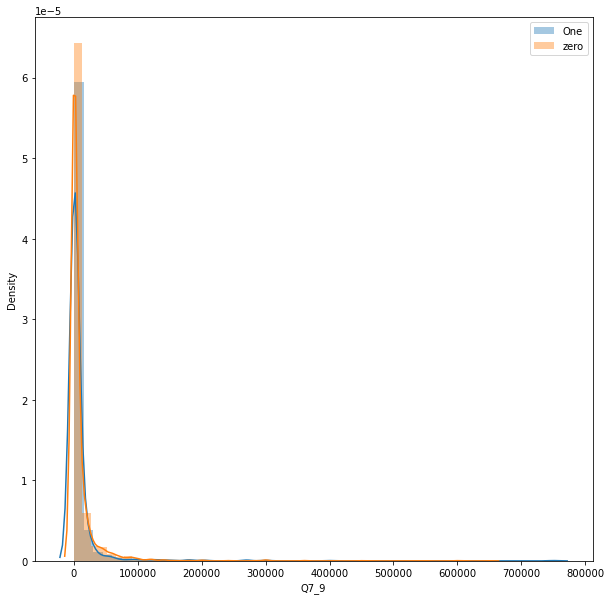

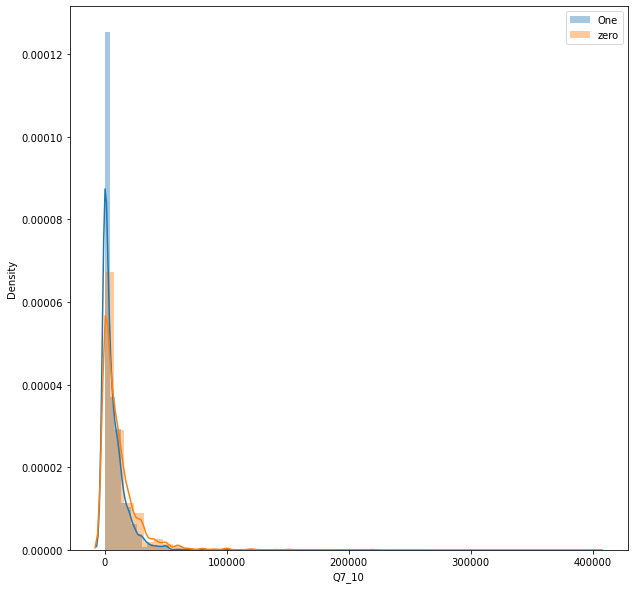

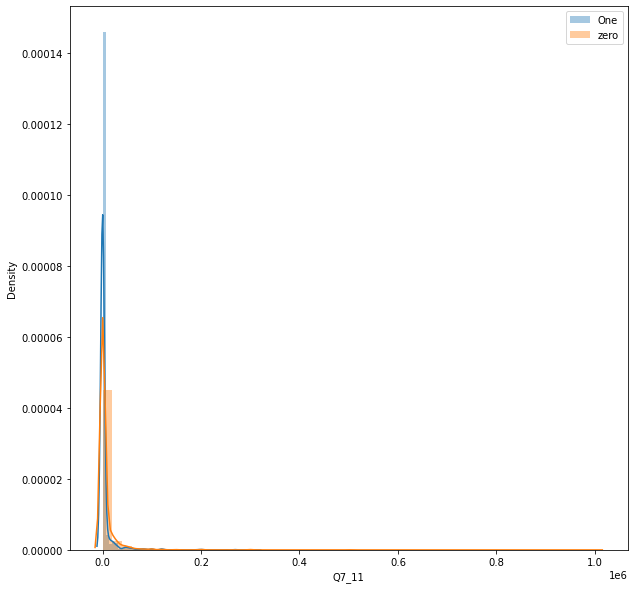

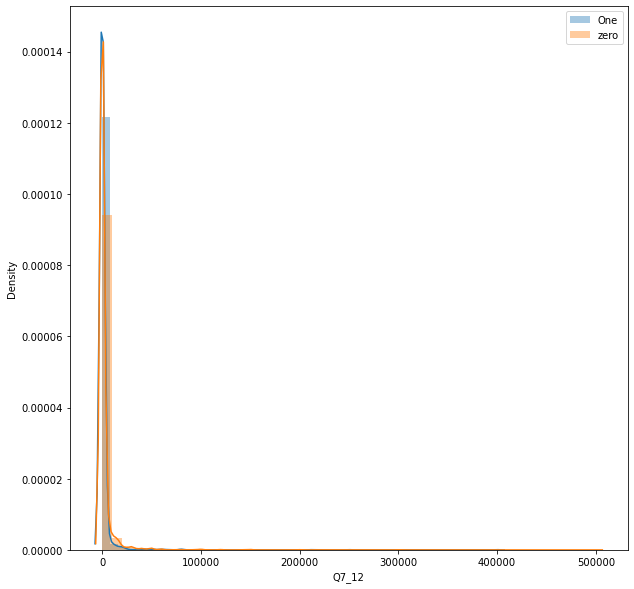

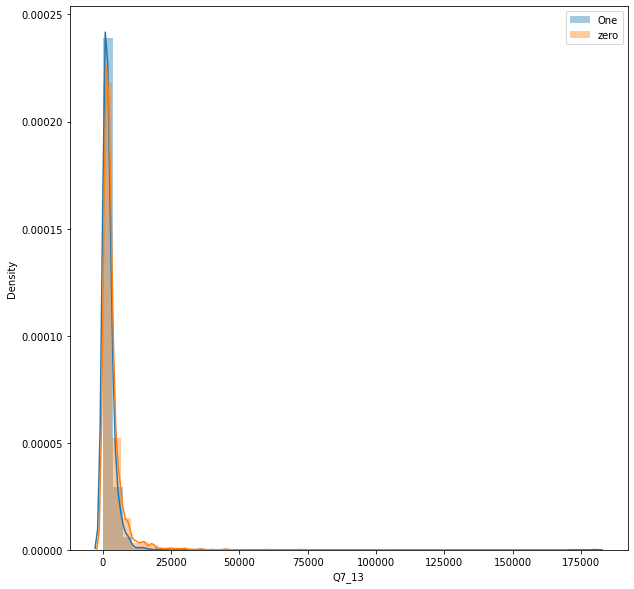

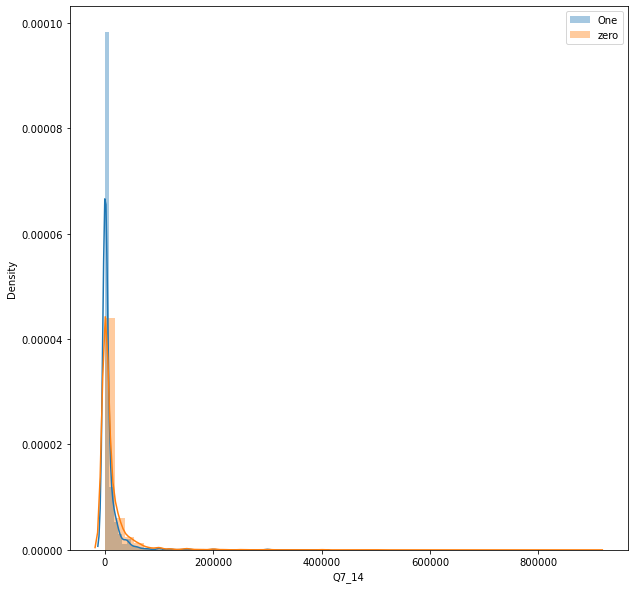

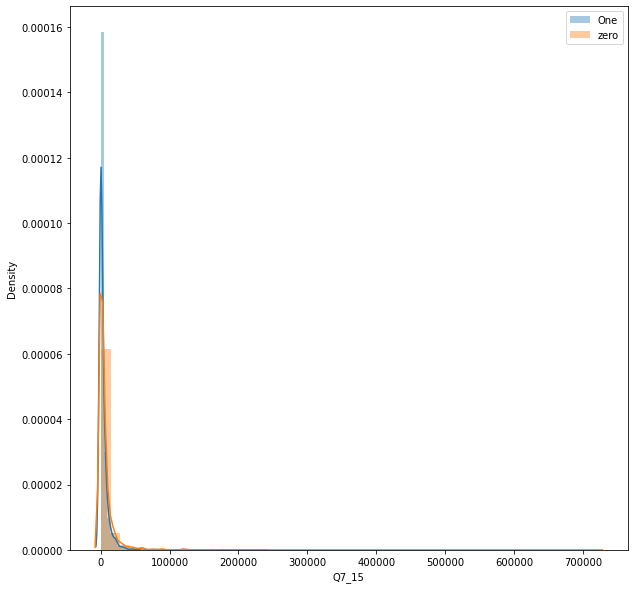

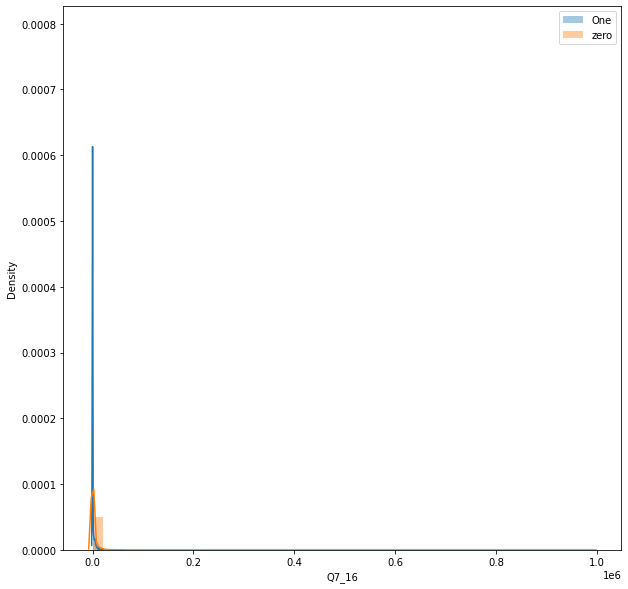

In [131]:
for col in Q7:
    plt.figure(figsize=(10,10))
    sns.distplot(df_IA_one[col], label= 'One')
    sns.distplot(df_IA_zero[col], label= 'zero')
    plt.legend()

In [185]:
Q7 = ["Q7_0a", "Q7_1"]

C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

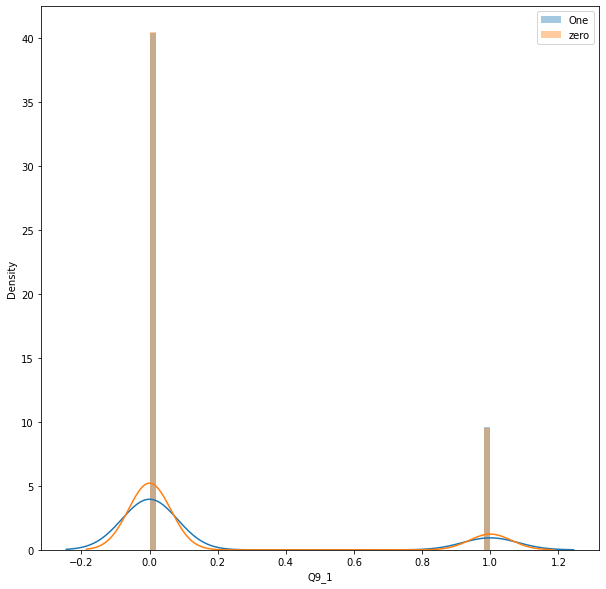

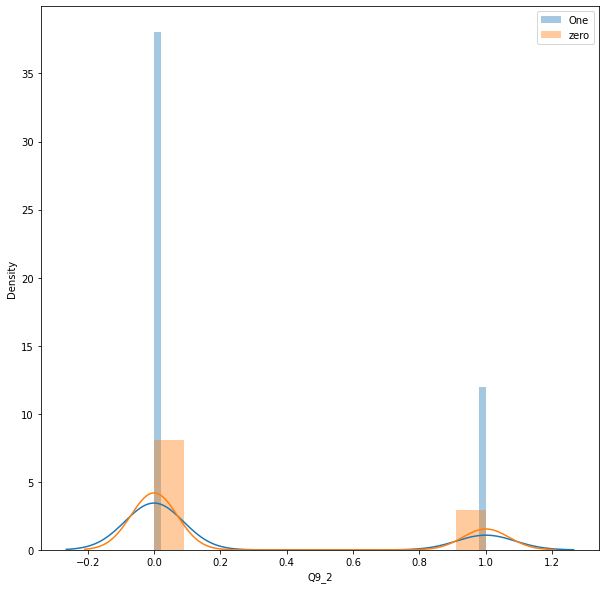

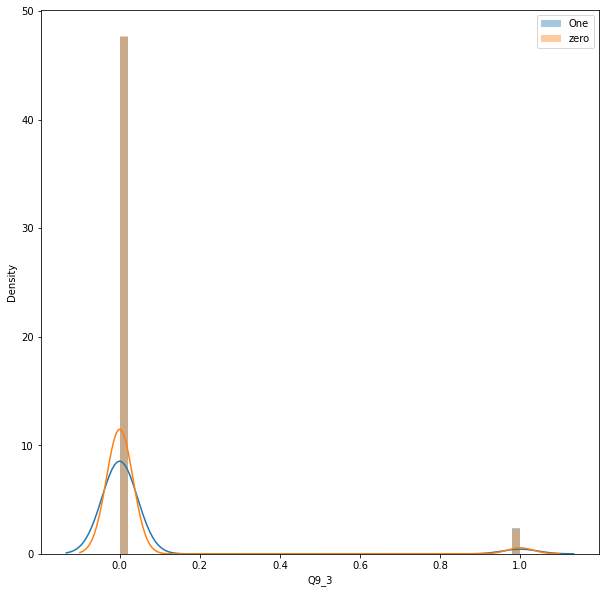

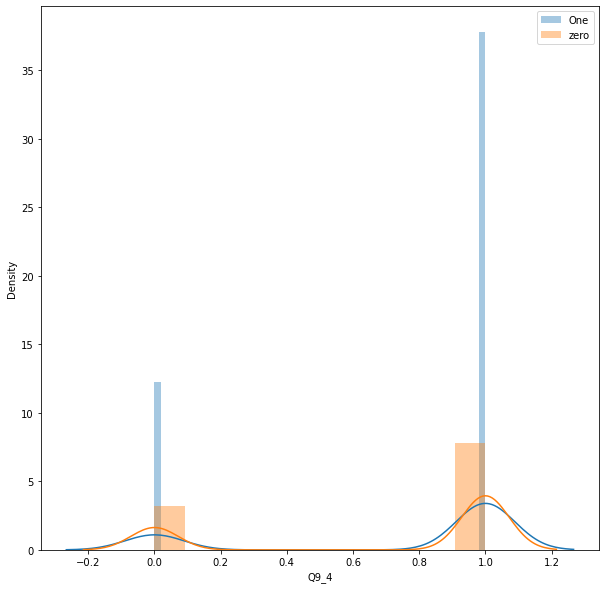

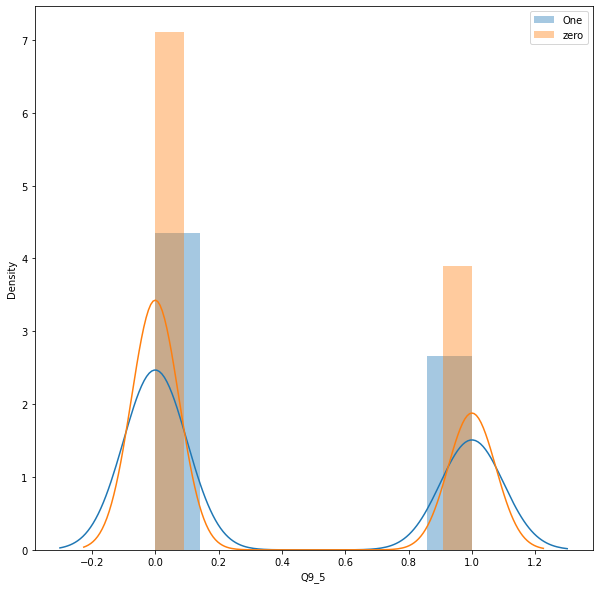

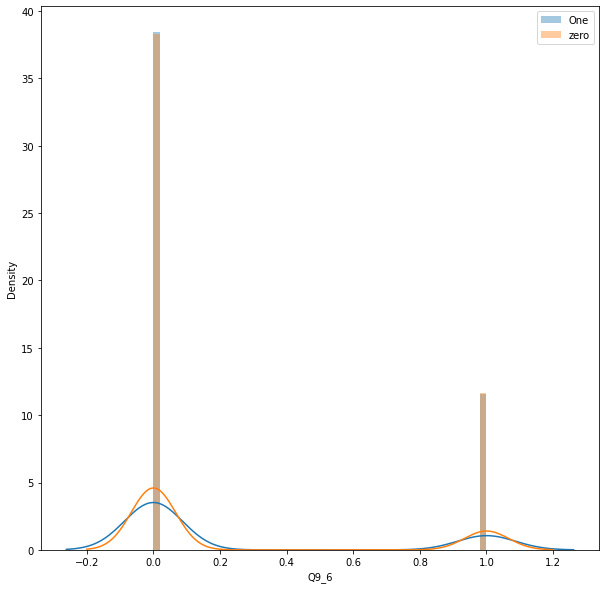

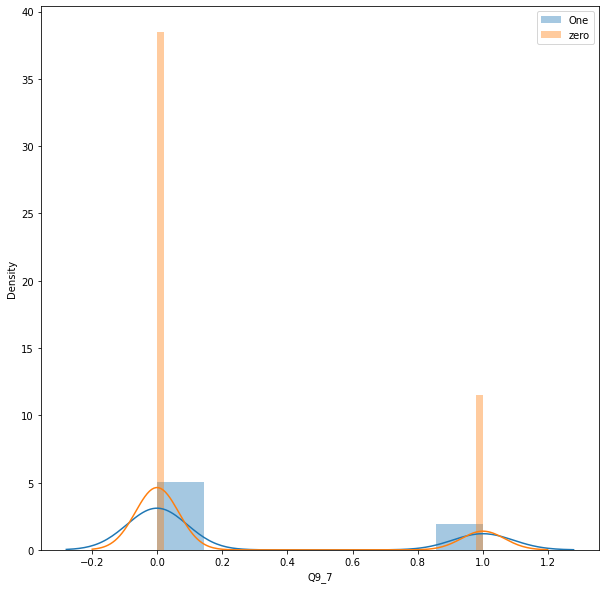

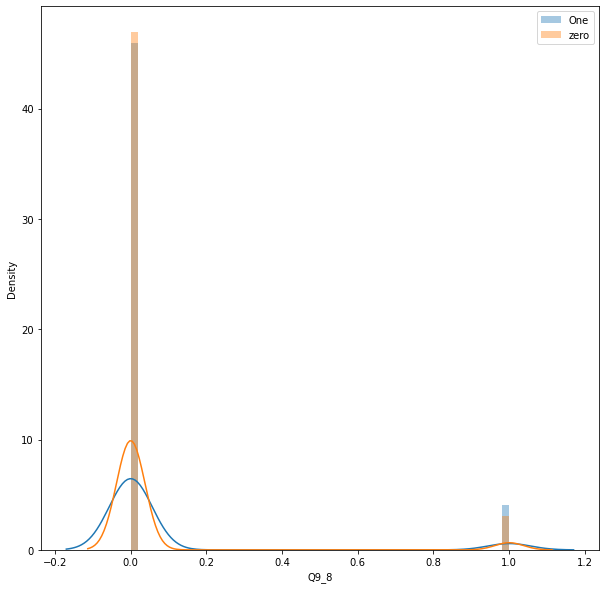

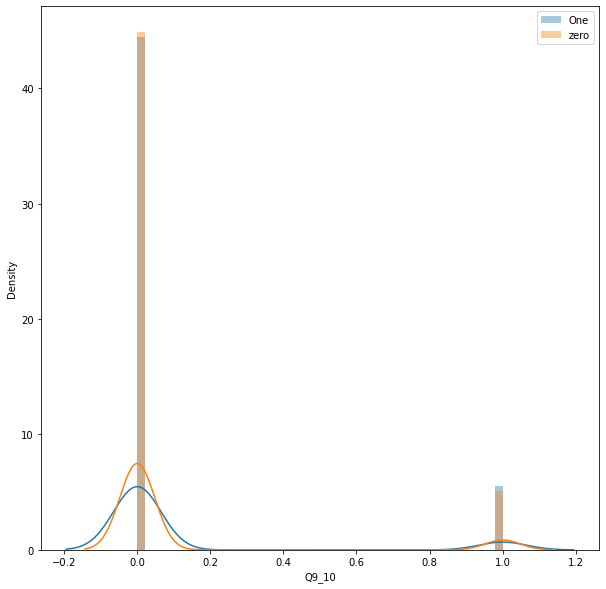

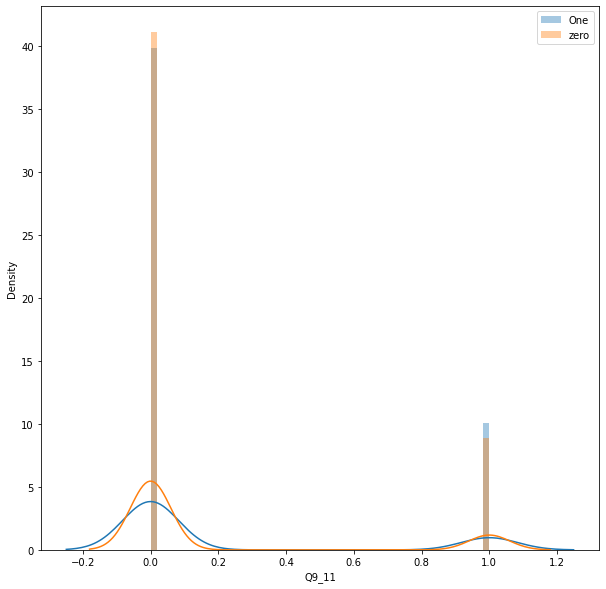

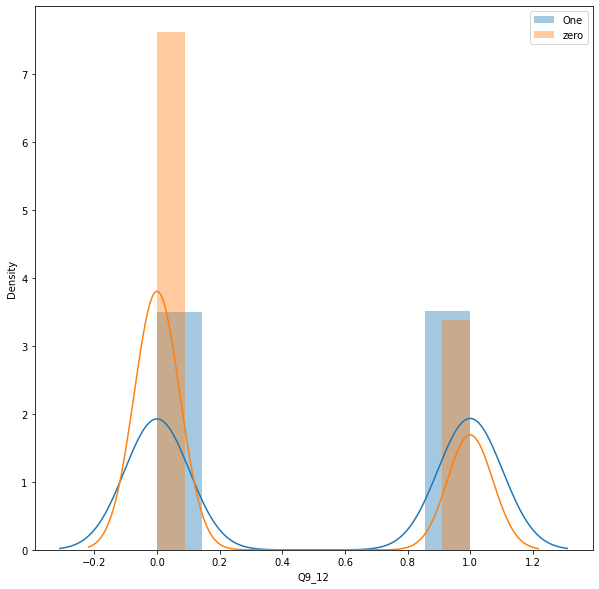

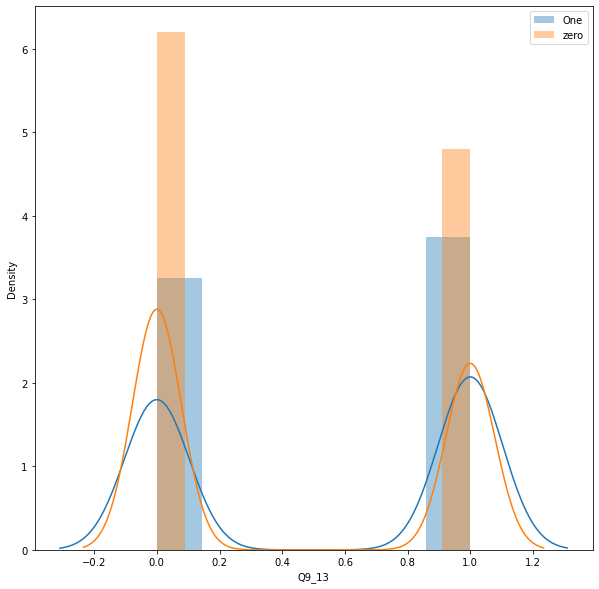

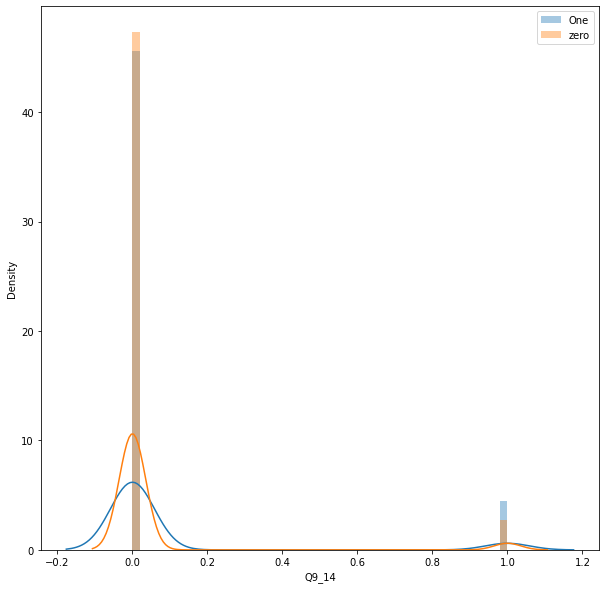

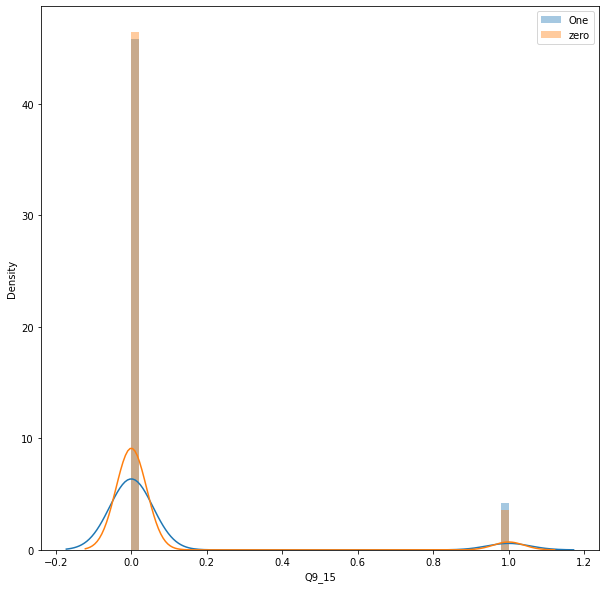

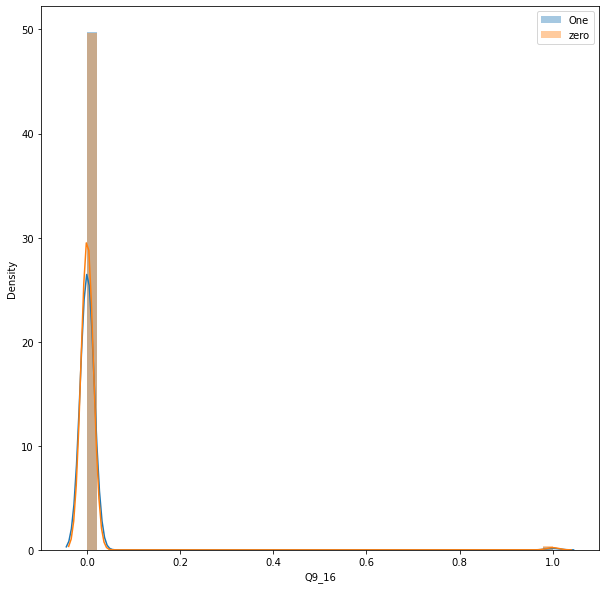

In [133]:
for col in Q9:
    plt.figure(figsize=(10,10))
    sns.distplot(df_IA_one[col], label= 'One')
    sns.distplot(df_IA_zero[col], label= 'zero')
    plt.legend()

In [186]:
Q9 = ["Q9_2","Q9_4","Q9_5","Q9_7", "Q9_12", "Q9_13"]

C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

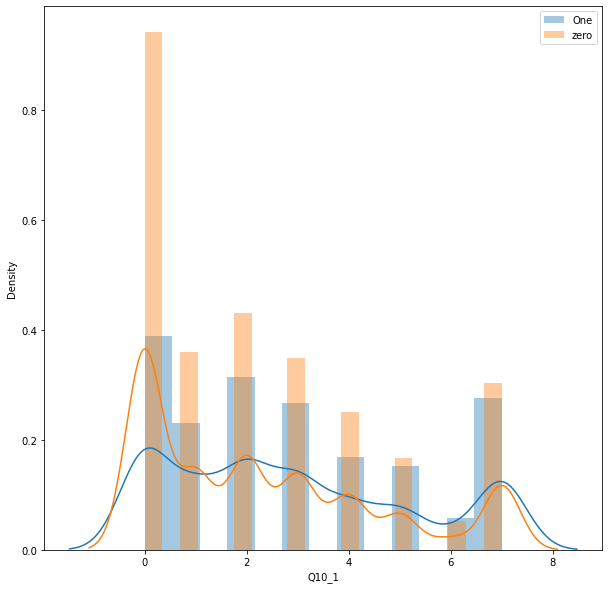

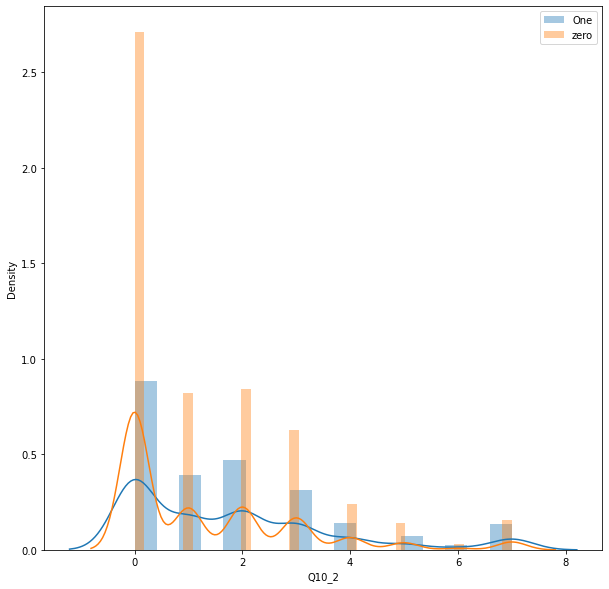

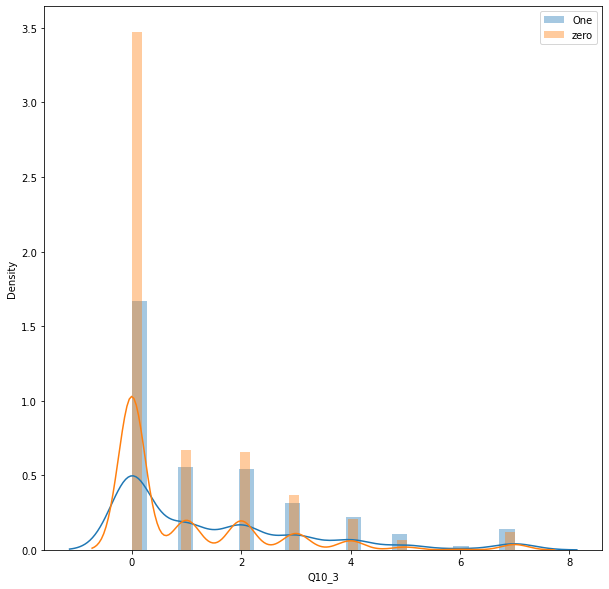

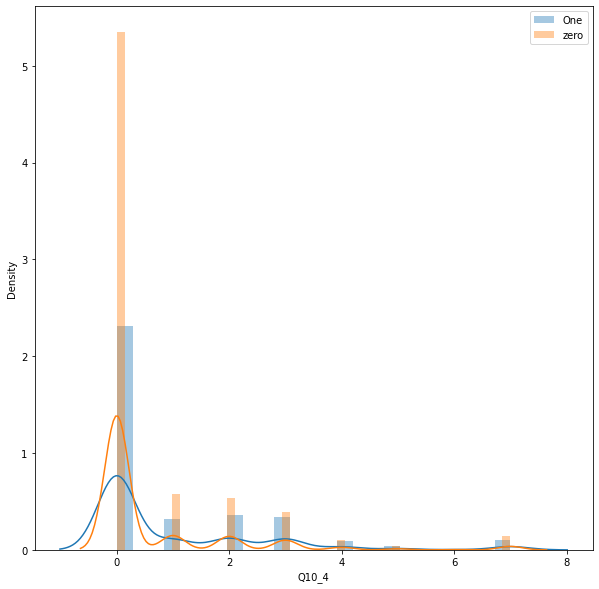

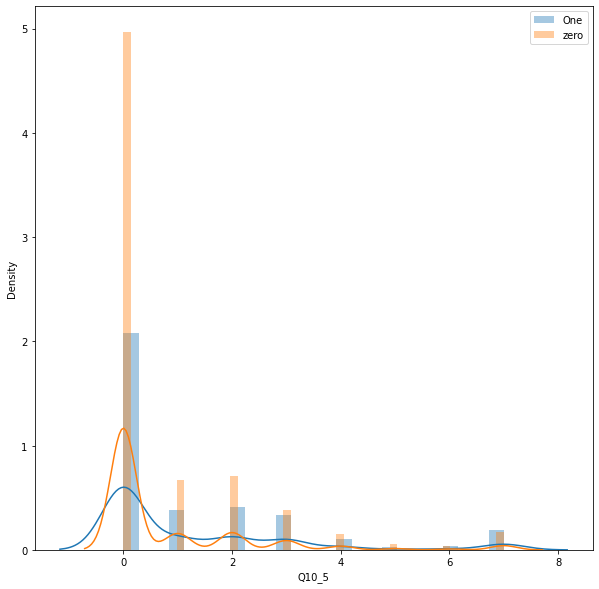

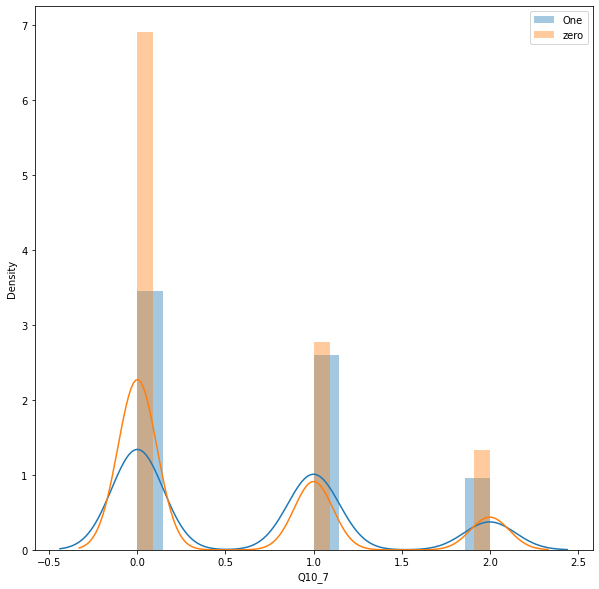

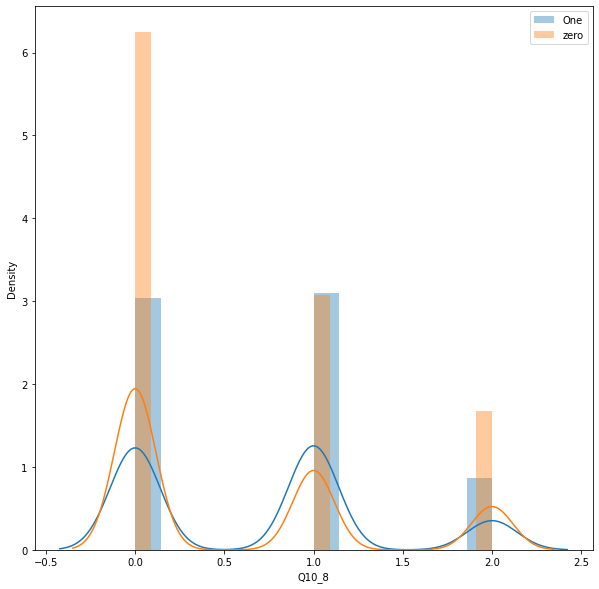

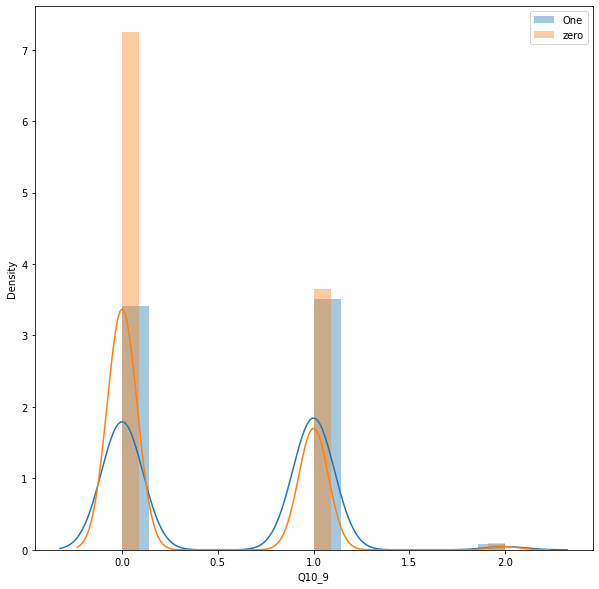

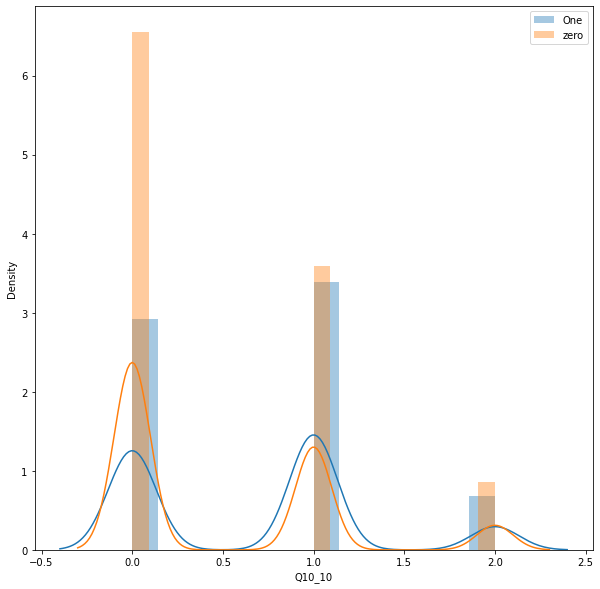

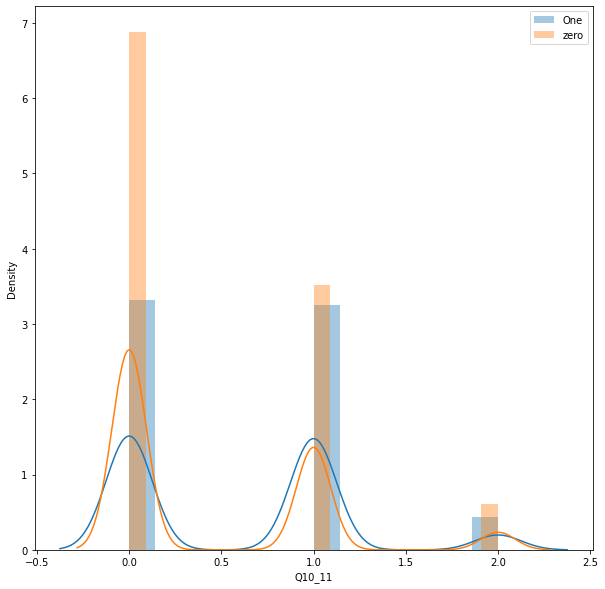

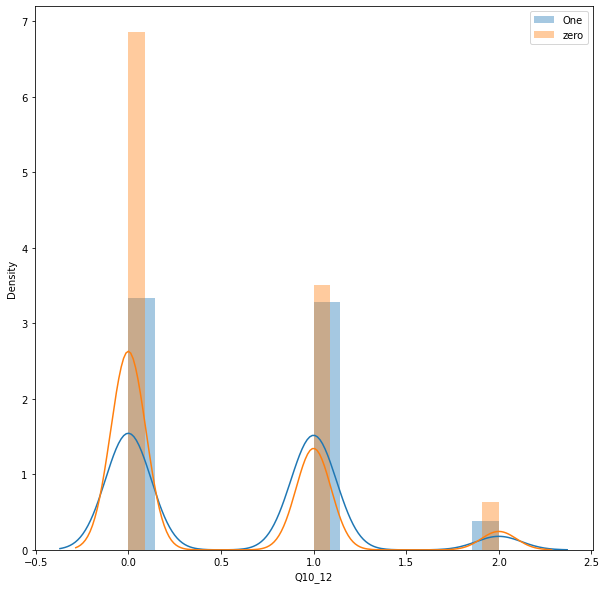

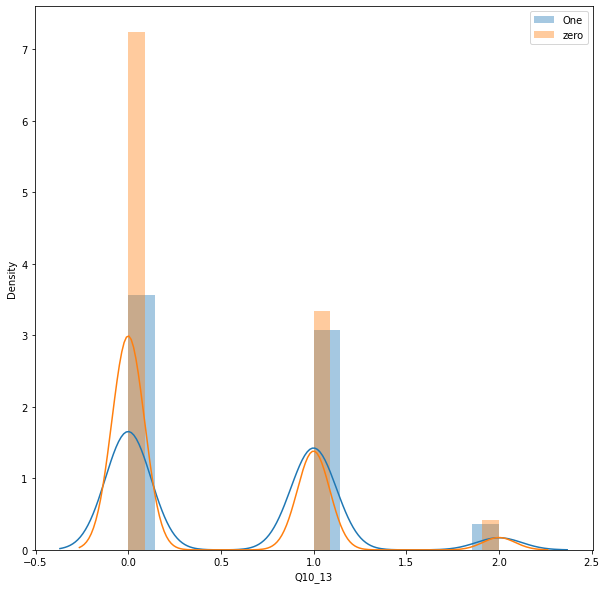

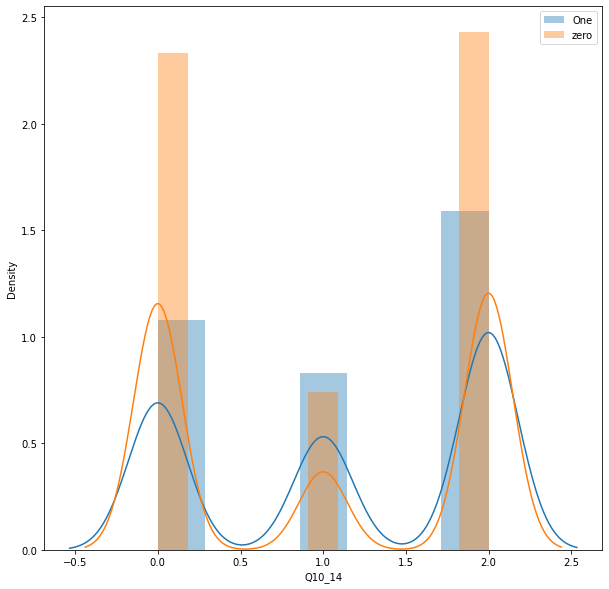

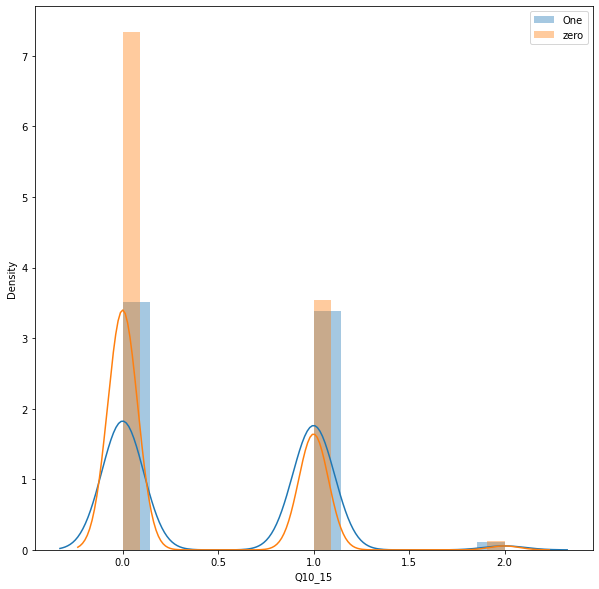

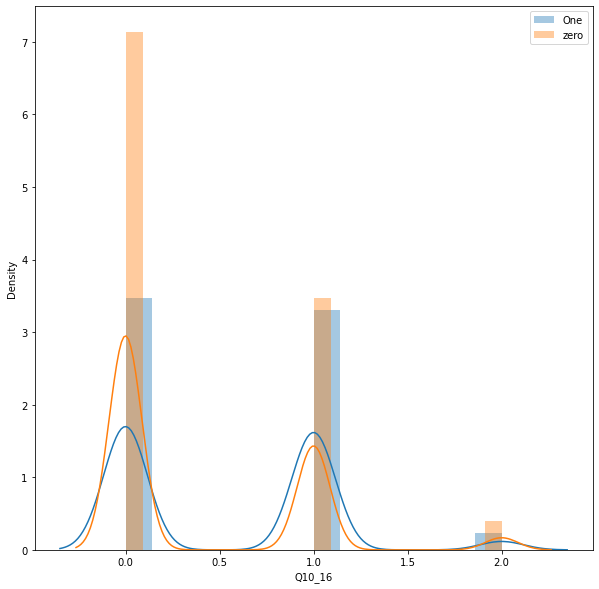

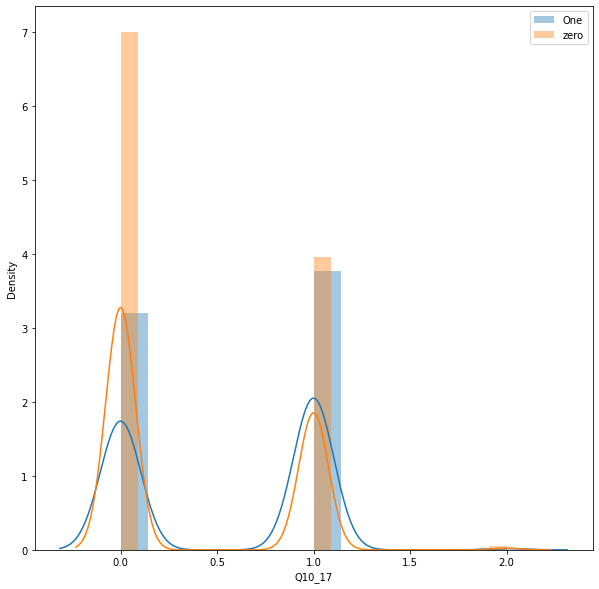

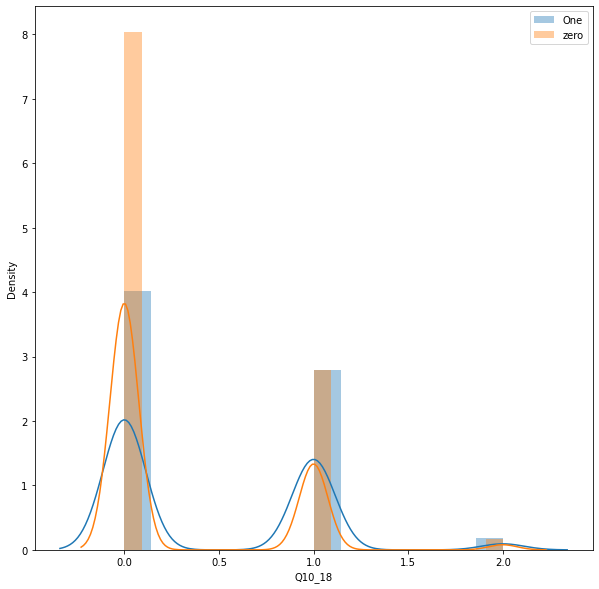

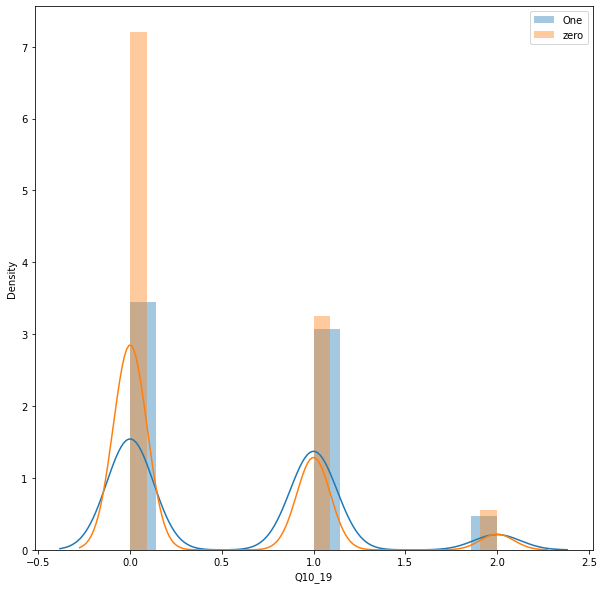

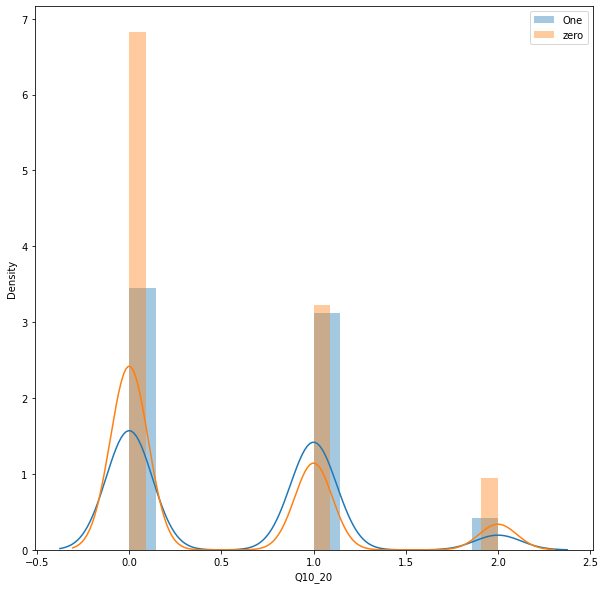

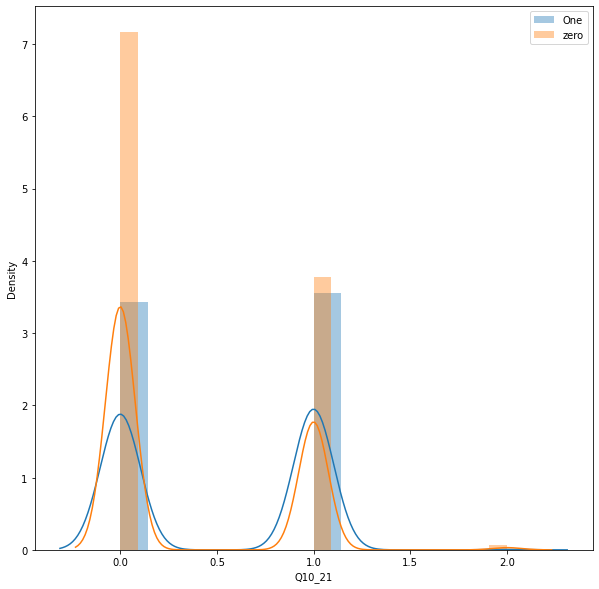

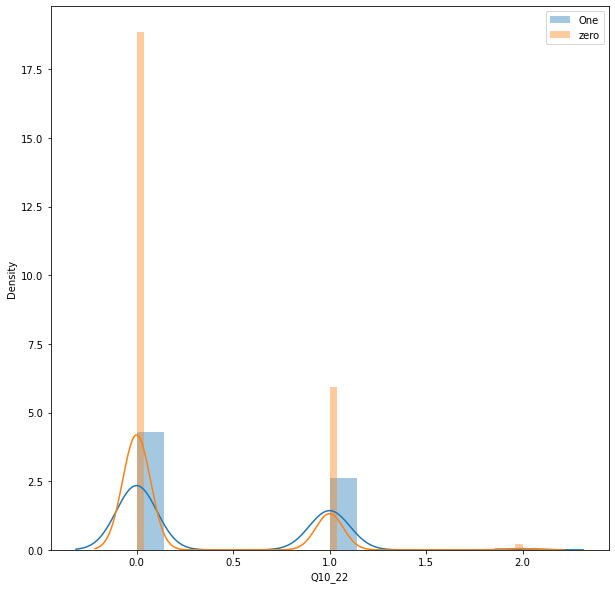

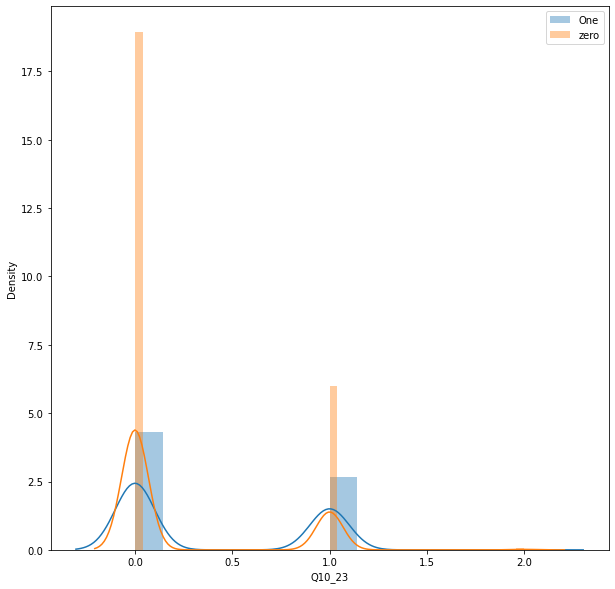

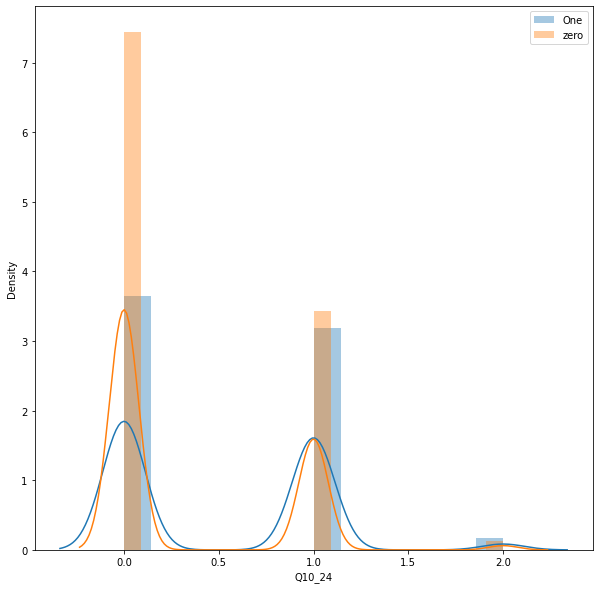

In [134]:
for col in Q10:
    plt.figure(figsize=(10,10))
    sns.distplot(df_IA_one[col], label= 'One')
    sns.distplot(df_IA_zero[col], label= 'zero')
    plt.legend()

In [188]:
Q10 = ["Q10_1","Q10_2","Q10_3","Q10_4","Q10_5","Q10_7","Q10_8","Q10_9","Q10_10","Q10_11","Q10_12","Q10_13","Q10_14","Q10_15","Q10_16","Q10_17","Q10_18","Q10_19","Q10_20","Q10_21","Q10_22","Q10_23","Q10_24"]

C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

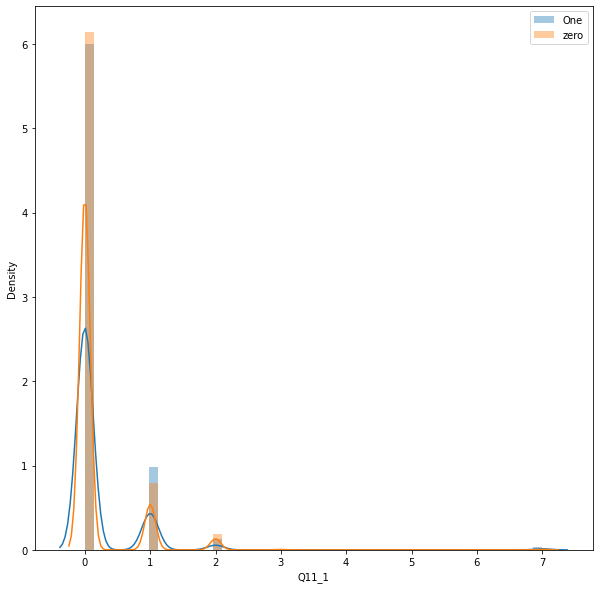

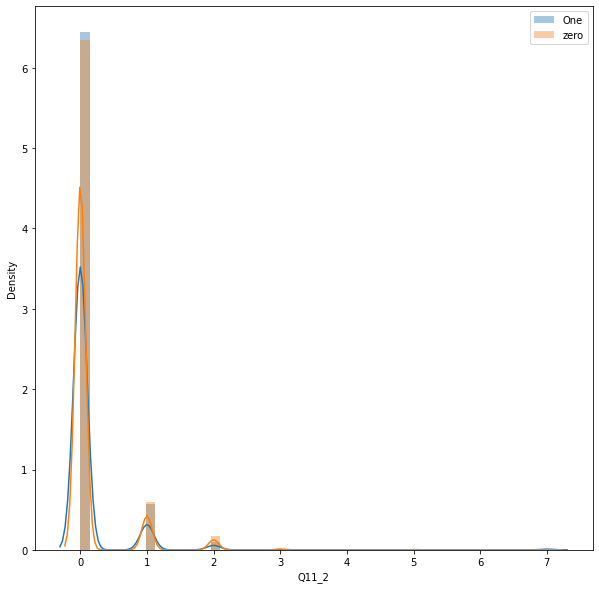

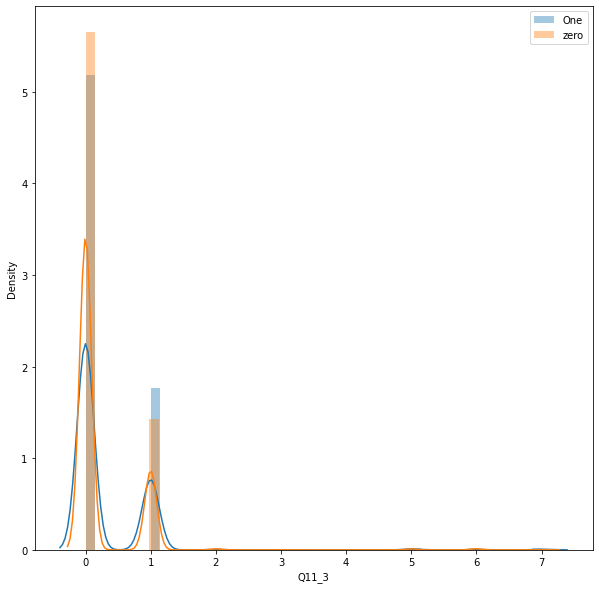

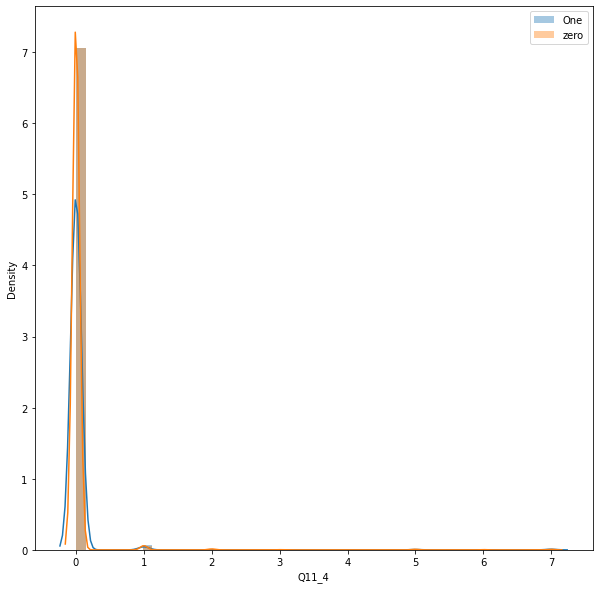

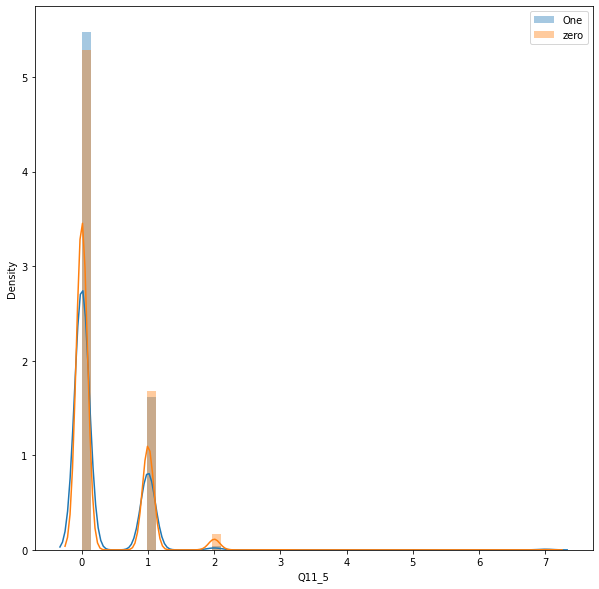

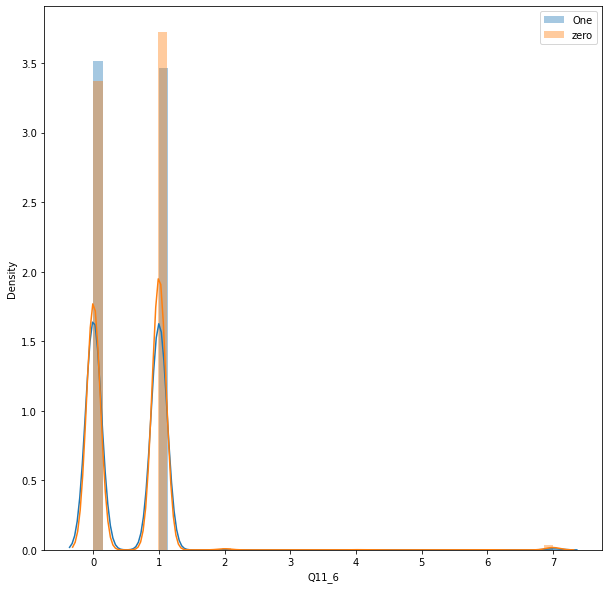

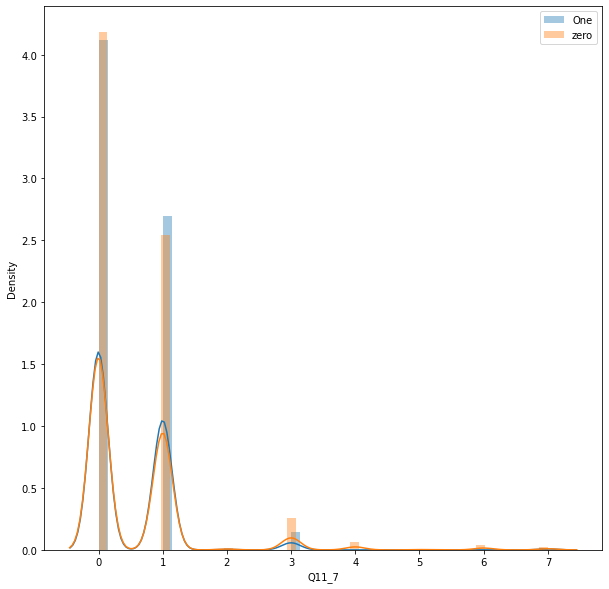

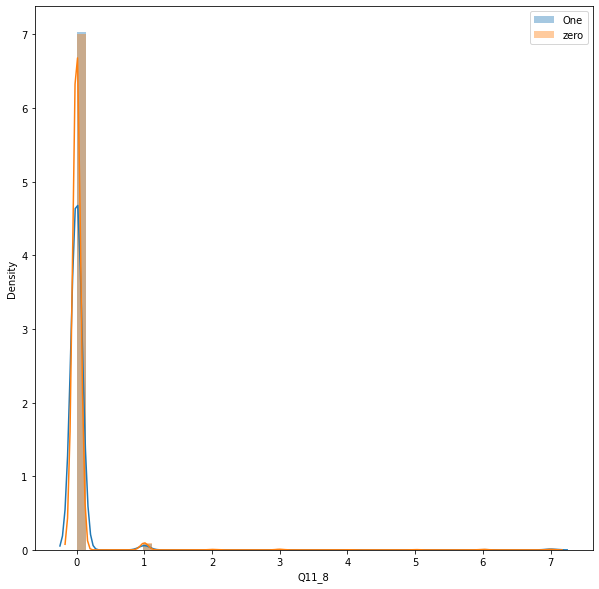

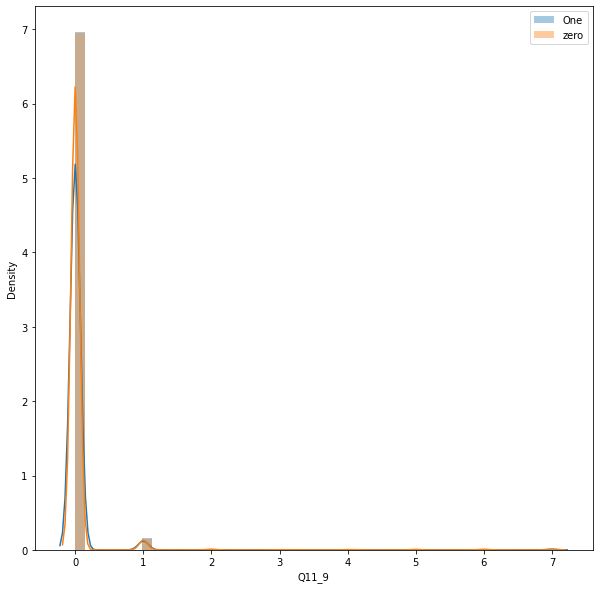

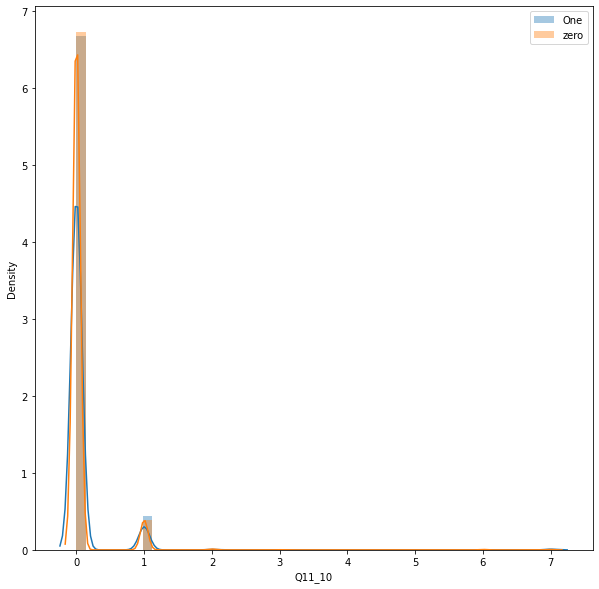

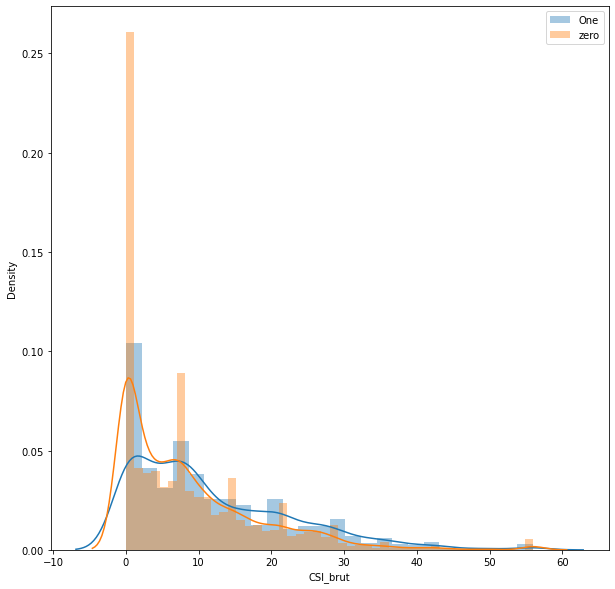

In [135]:
for col in Q11:
    plt.figure(figsize=(10,10))
    sns.distplot(df_IA_one[col], label= 'One')
    sns.distplot(df_IA_zero[col], label= 'zero')
    plt.legend()

not selected

C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

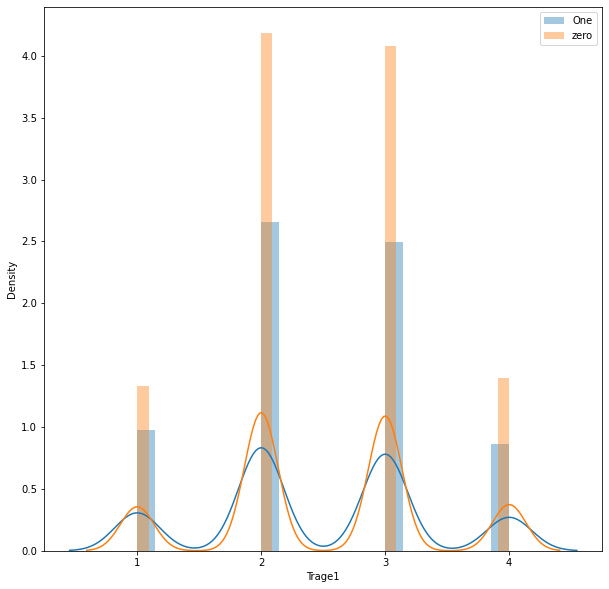

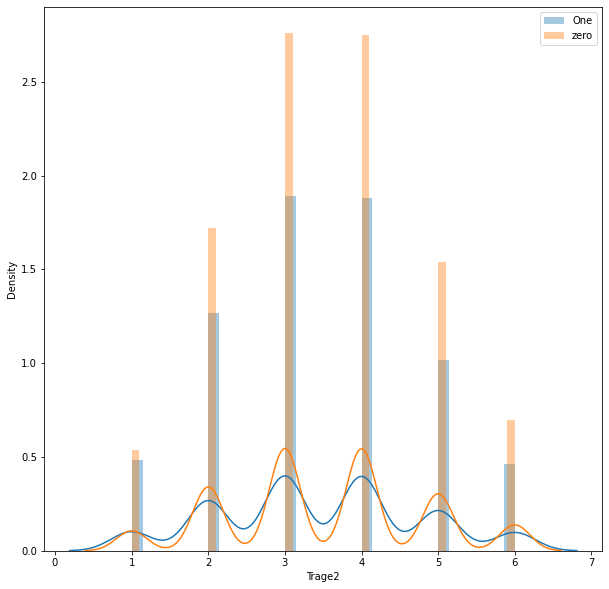

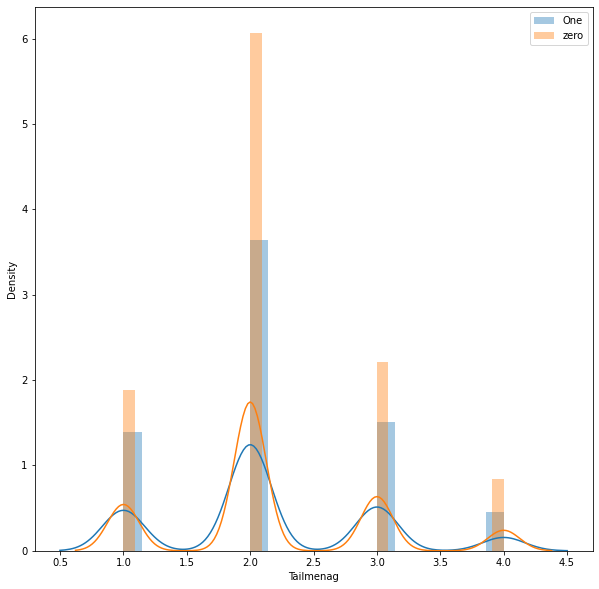

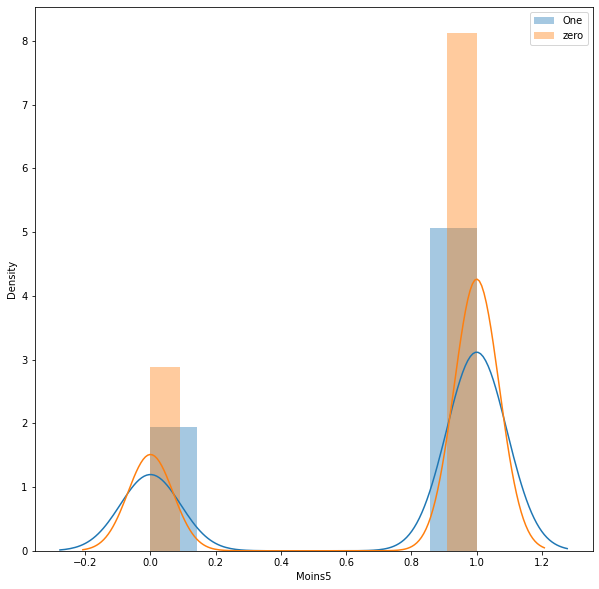

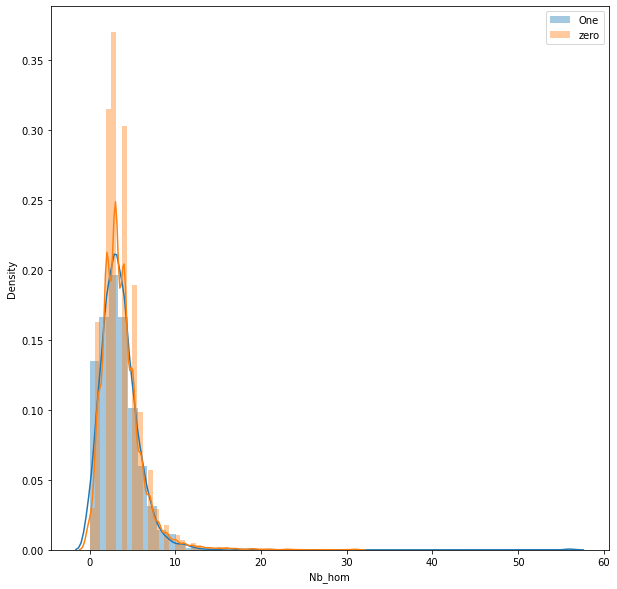

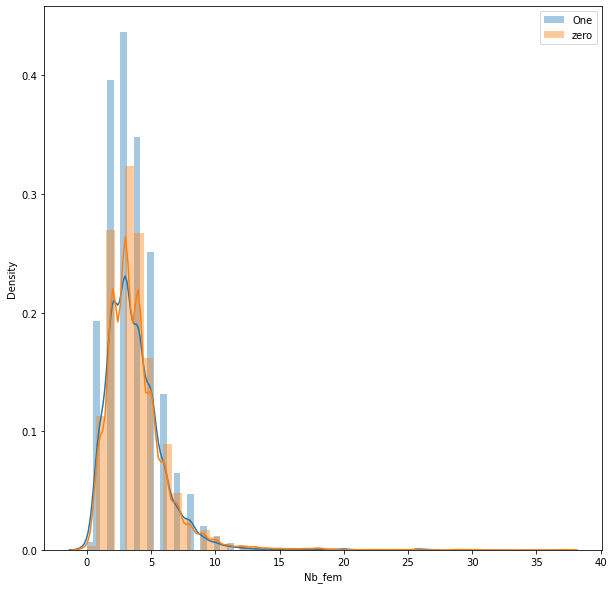

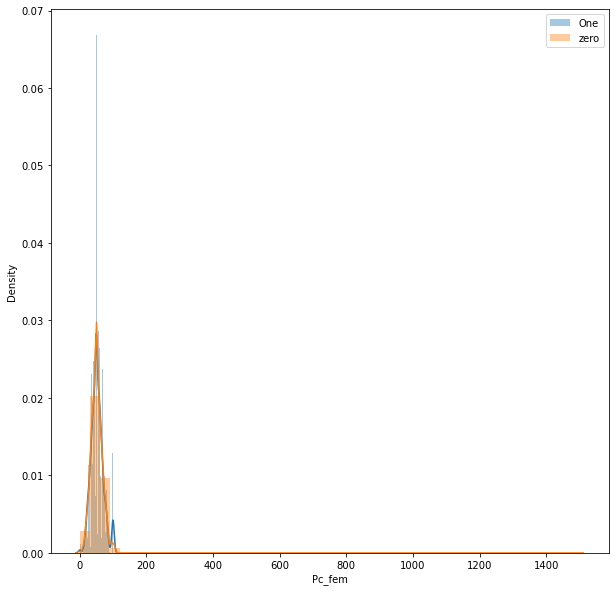

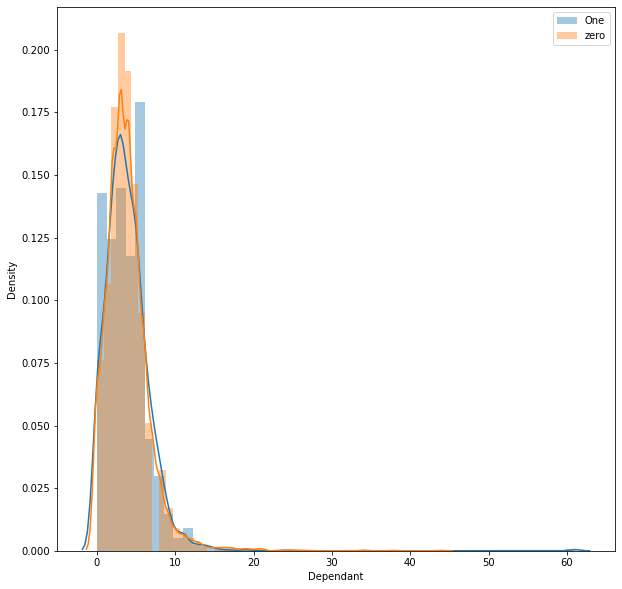

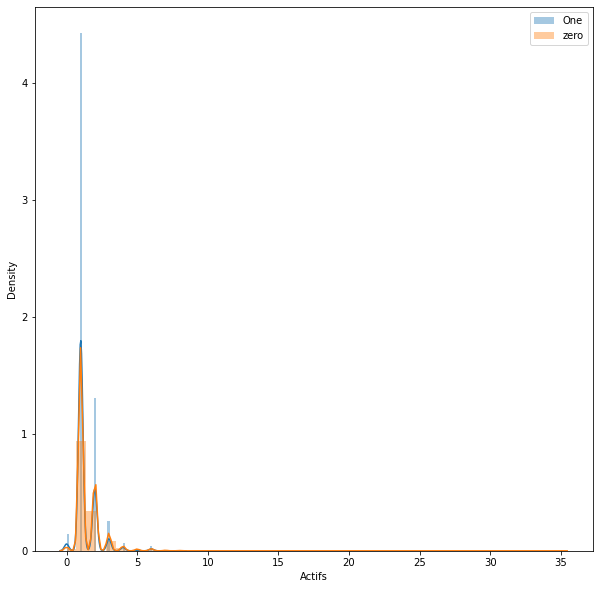

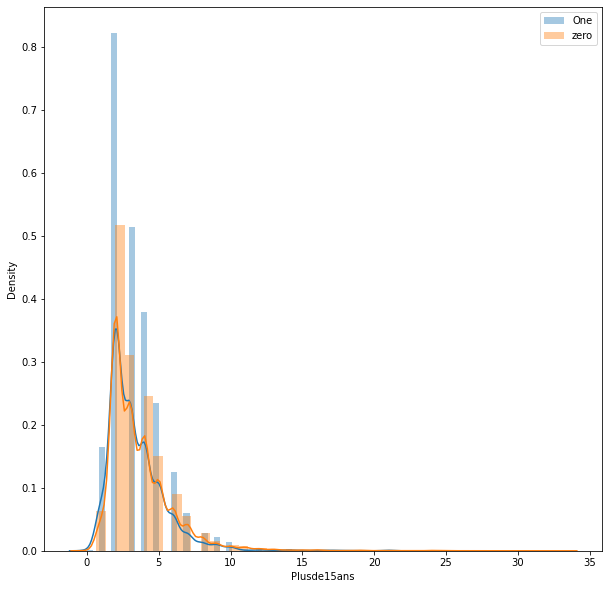

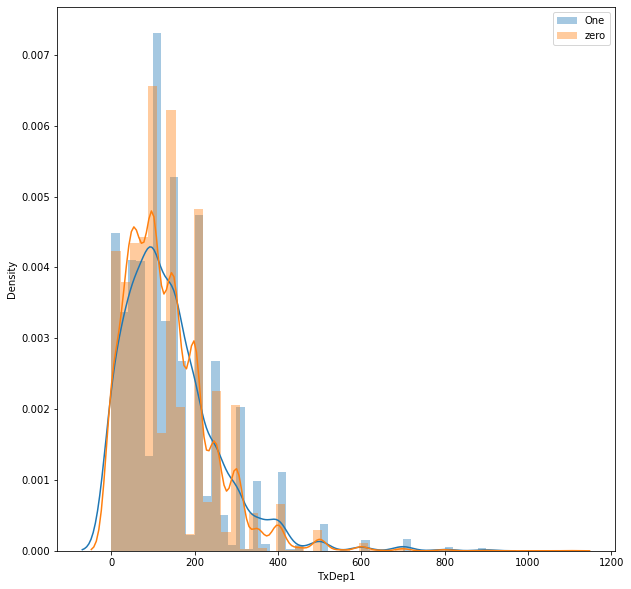

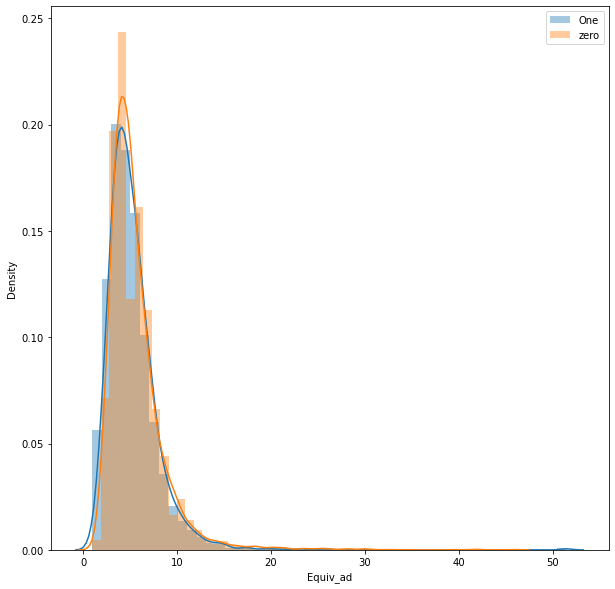

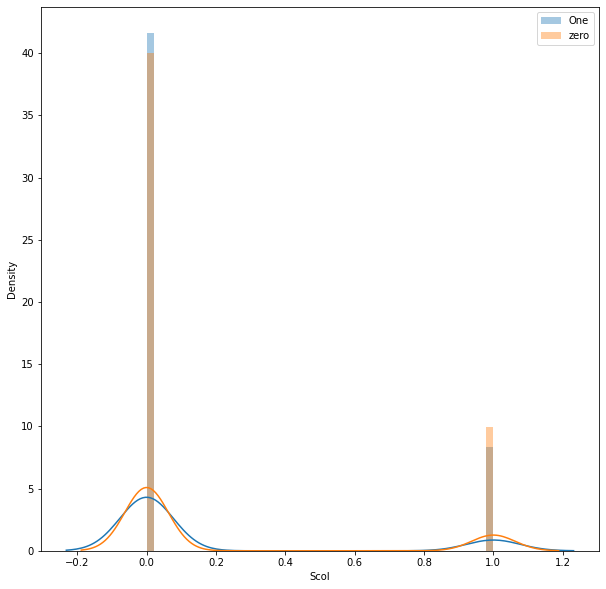

In [136]:
for col in other:
    plt.figure(figsize=(10,10))
    sns.distplot(df_IA_one[col], label= 'One')
    sns.distplot(df_IA_zero[col], label= 'zero')
    plt.legend()

not selected

C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

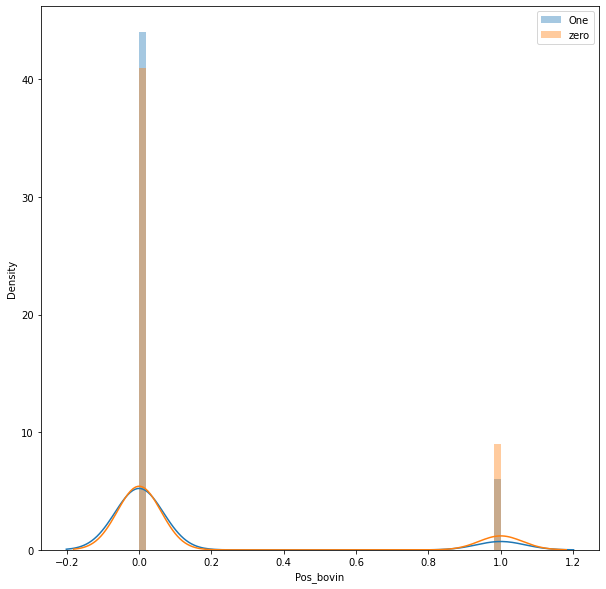

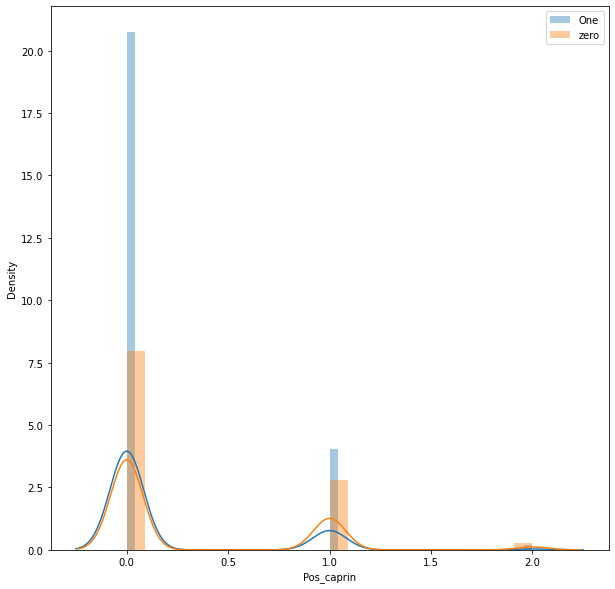

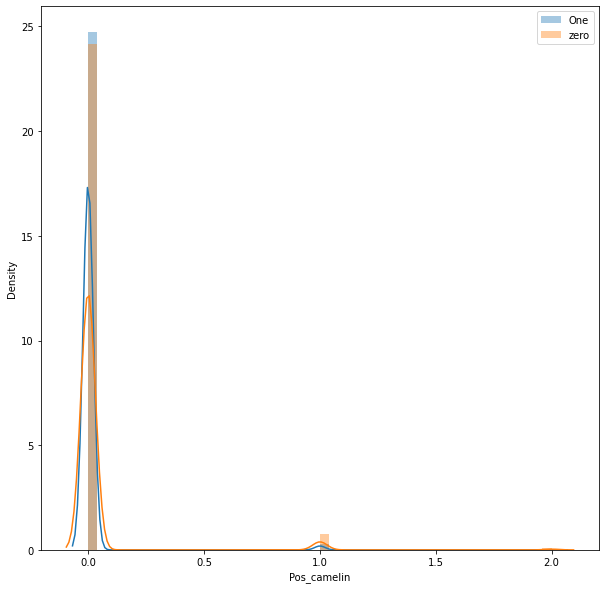

In [137]:
for col in pos:
    plt.figure(figsize=(10,10))
    sns.distplot(df_IA_one[col], label= 'One')
    sns.distplot(df_IA_zero[col], label= 'zero')
    plt.legend()

not selected

C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

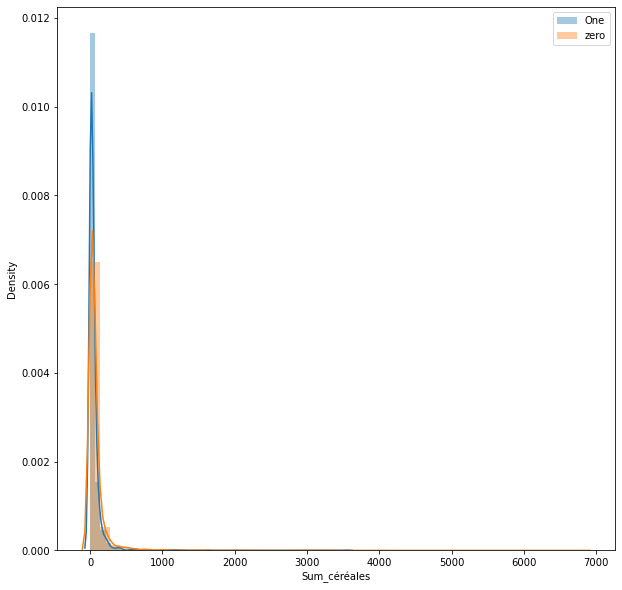

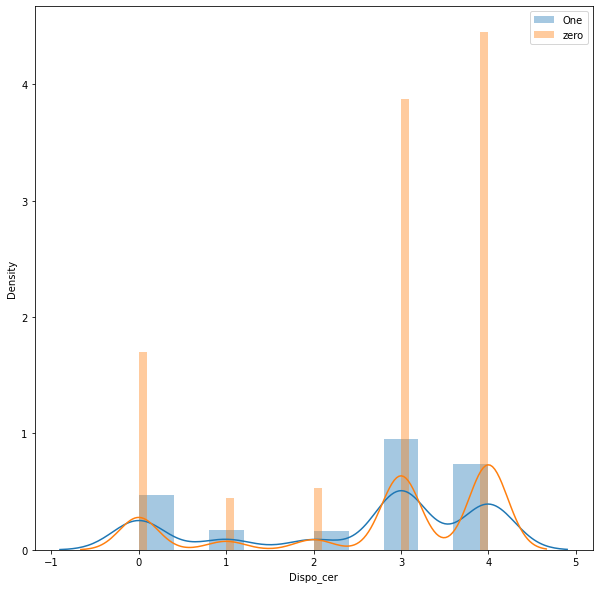

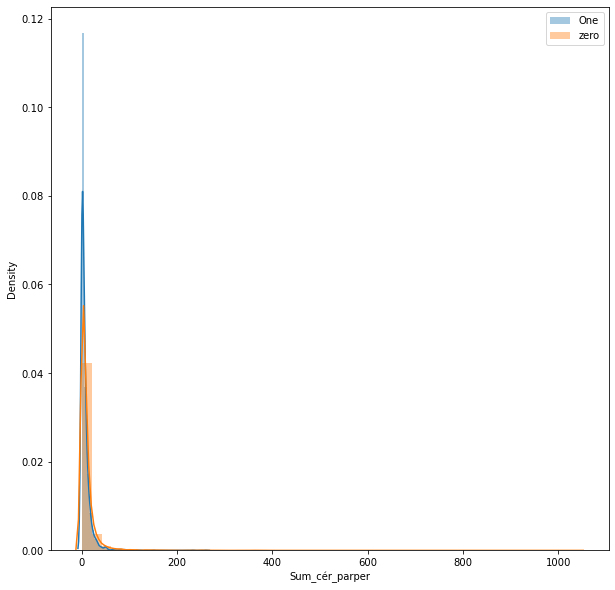

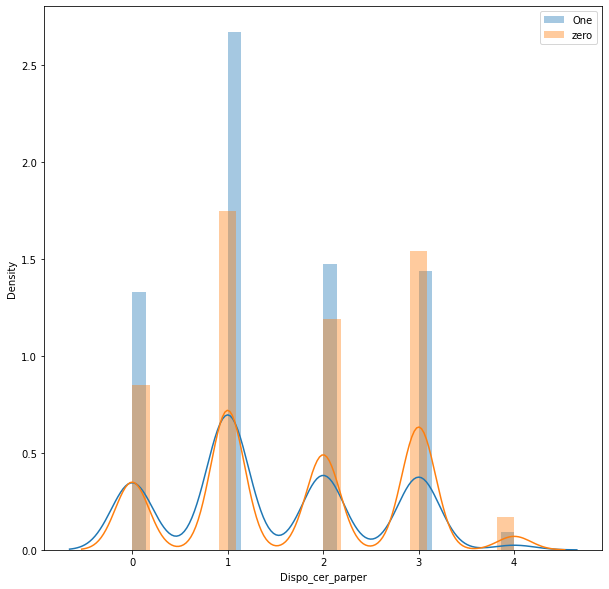

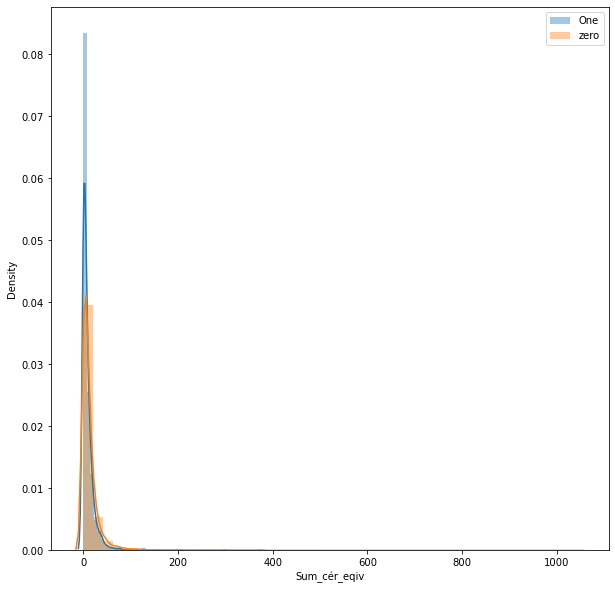

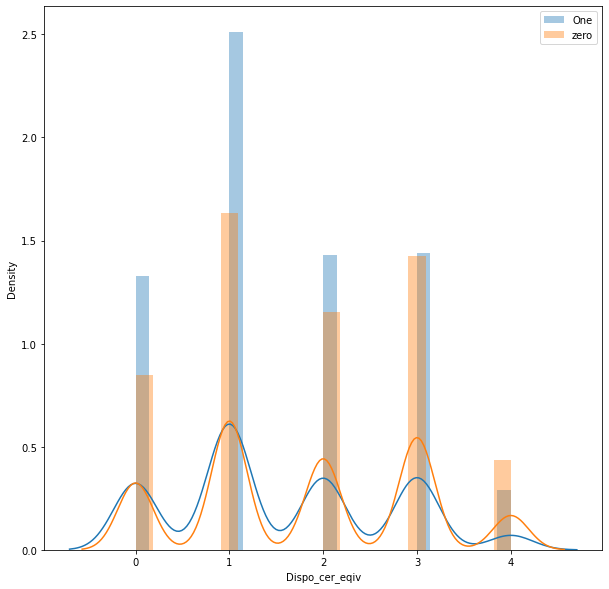

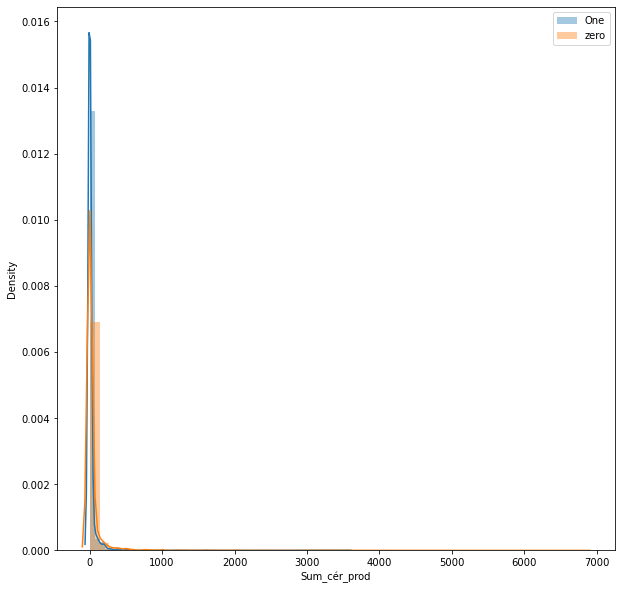

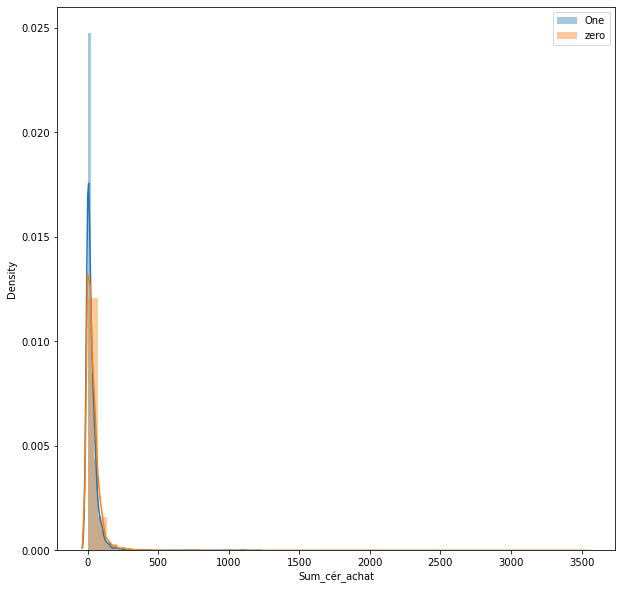

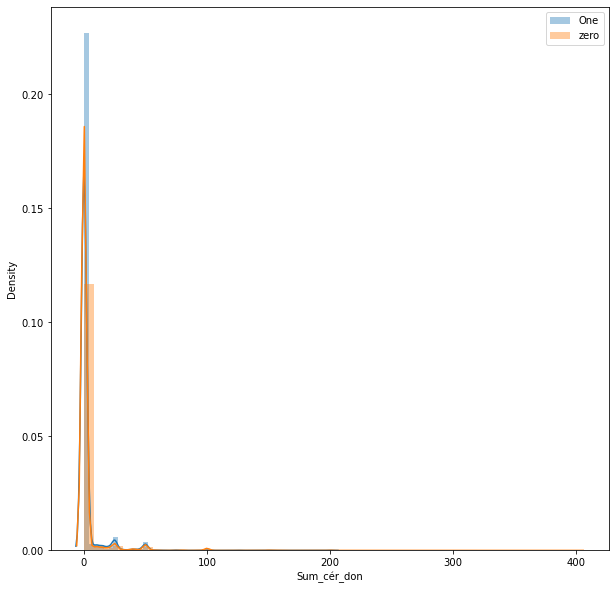

In [138]:
for col in sumd:
    plt.figure(figsize=(10,10))
    sns.distplot(df_IA_one[col], label= 'One')
    sns.distplot(df_IA_zero[col], label= 'zero')
    plt.legend()

In [189]:
other = ["Dispo_cer"]

C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\froge\.conda\envs\analyse\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

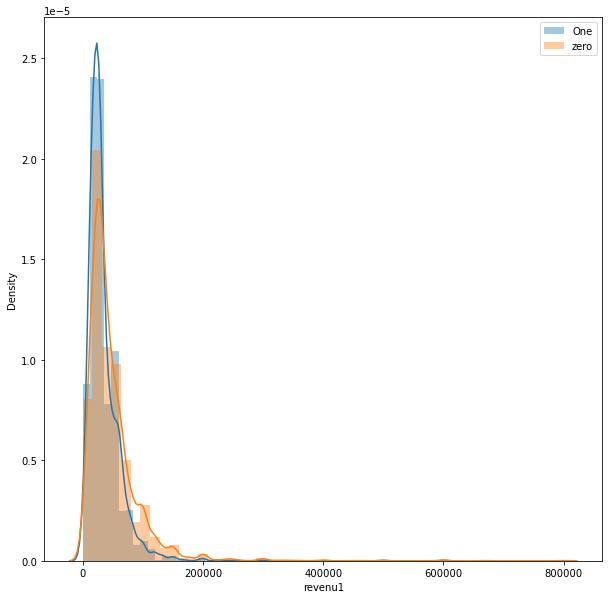

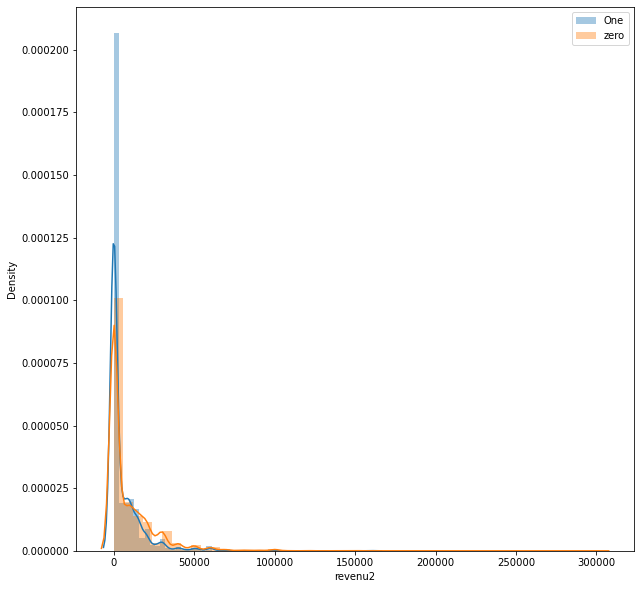

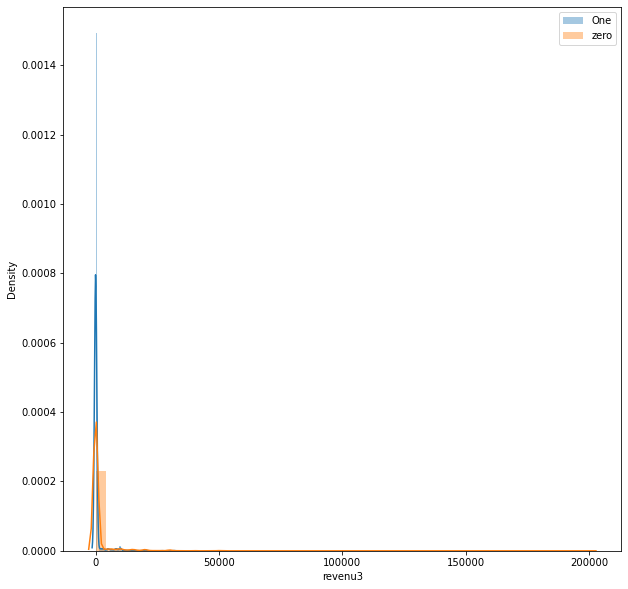

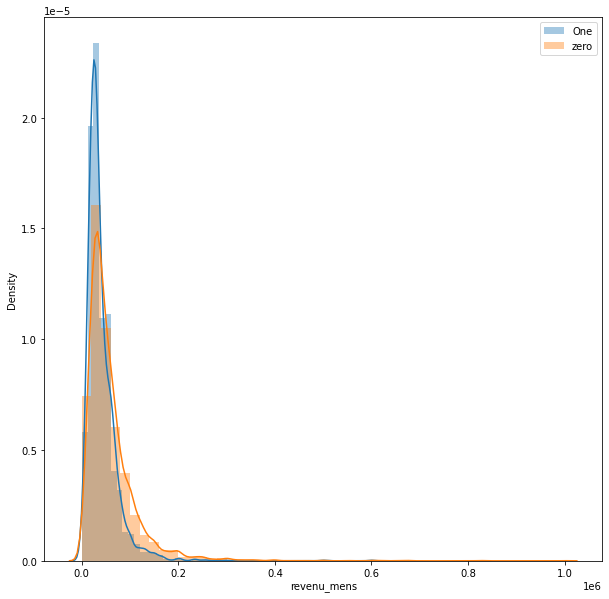

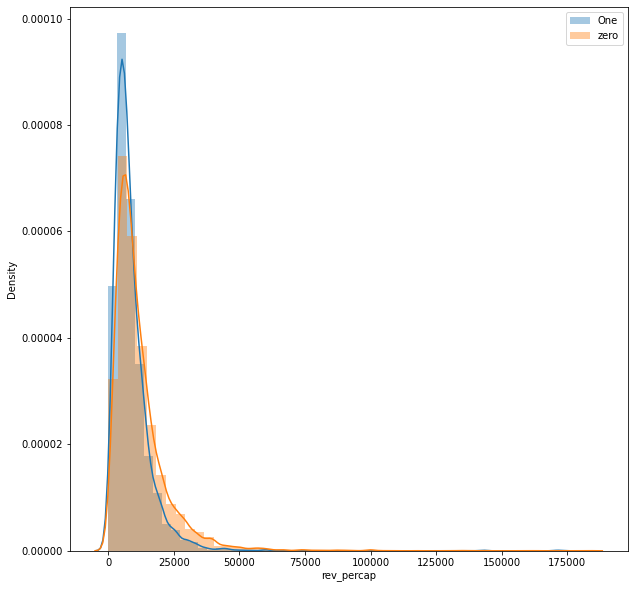

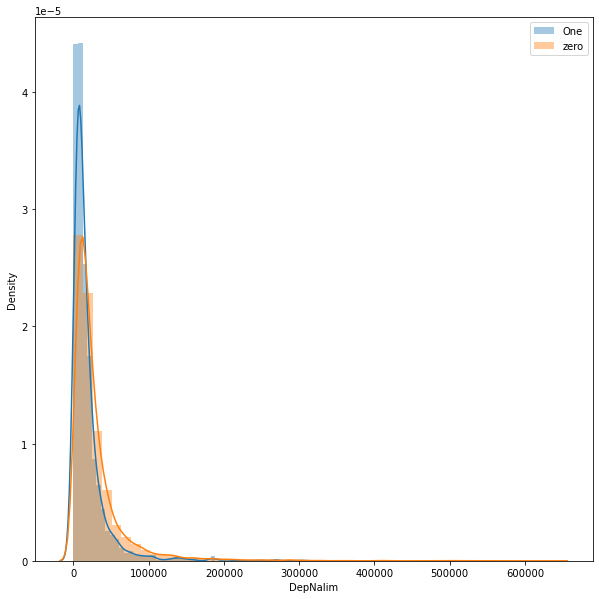

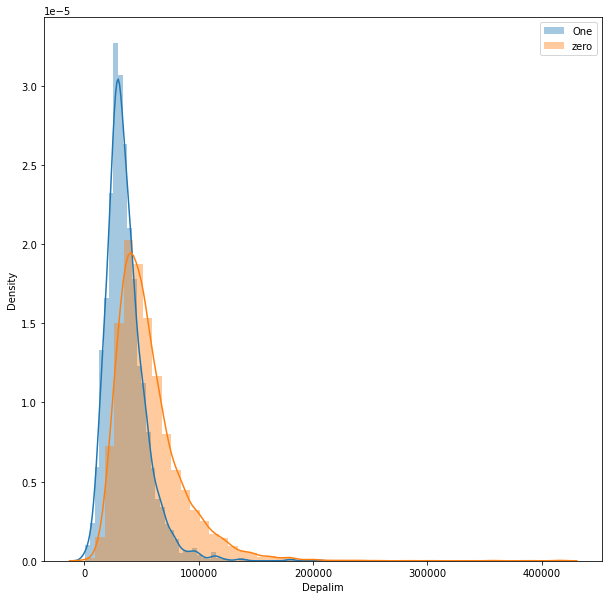

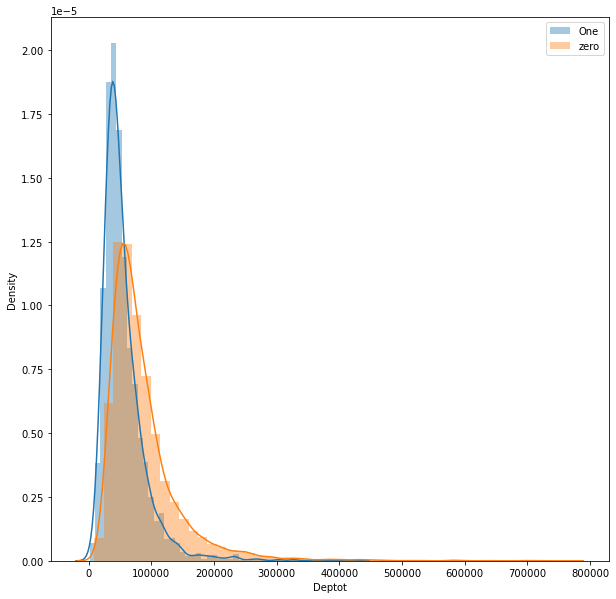

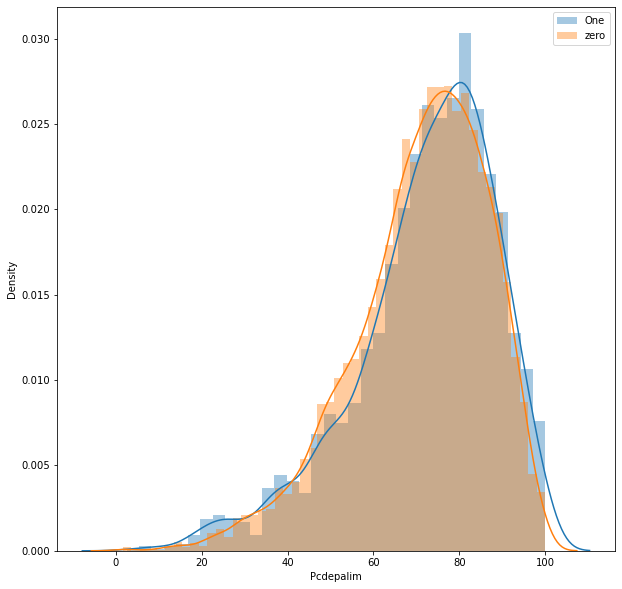

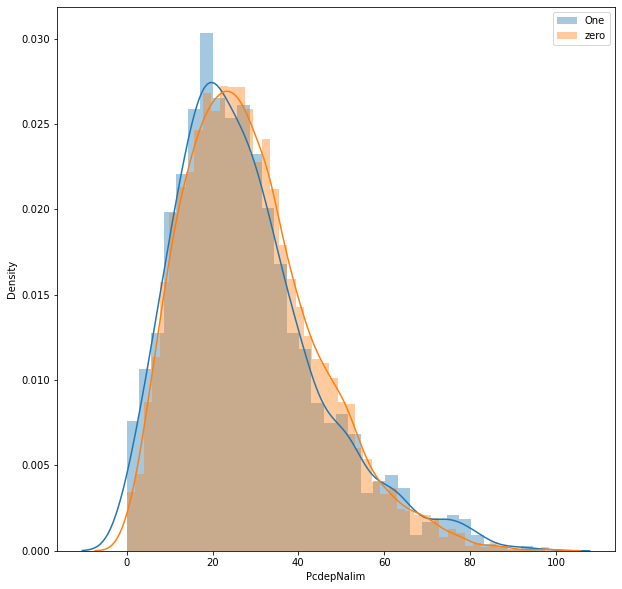

In [139]:
for col in revenu:
    plt.figure(figsize=(10,10))
    sns.distplot(df_IA_one[col], label= 'One')
    sns.distplot(df_IA_zero[col], label= 'zero')
    plt.legend()

not selected

In [348]:
target =['IA']
Q4 = ["Q4_5_1", "Q4_6_1","Q4_7_1", "Q4_8_1"]
df_selected = df_modele[Q4 + Q2 + Q6 + Q7 + Q9 + Q10 + other + target]
 

*checking correlations*

<AxesSubplot:>

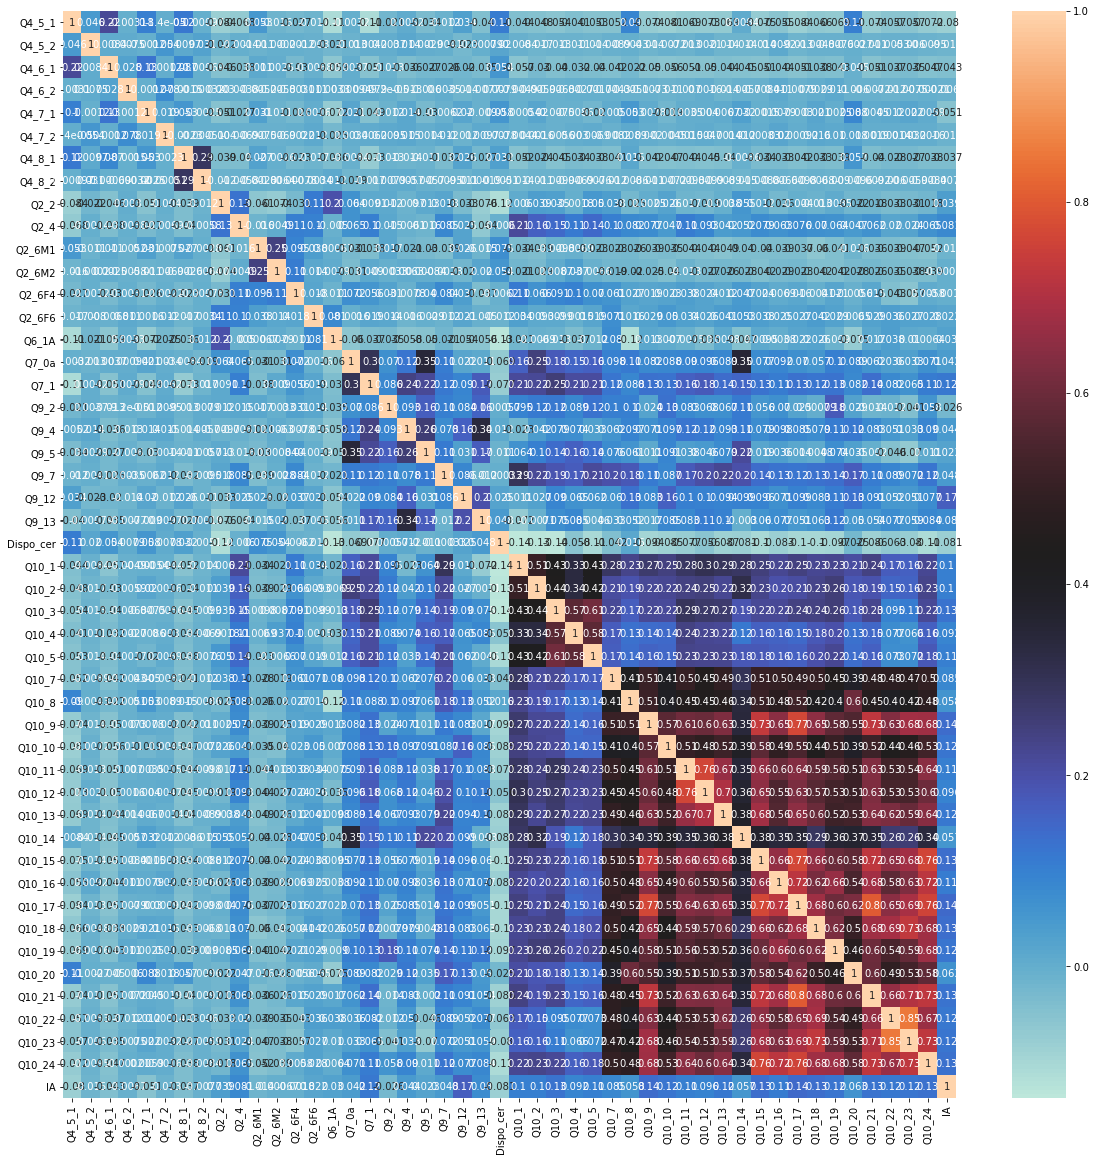

In [167]:
matrix = df_selected.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(matrix,annot=True, cmap="icefire")

In [349]:
#corr drop
drop = ["Q10_3","Q10_4","Q10_5","Q10_8","Q10_9",
        "Q10_10","Q10_11","Q10_12","Q10_13","Q10_14",
        "Q10_16","Q10_17","Q10_18","Q10_19","Q10_20",
        "Q10_21","Q10_22","Q10_23","Q10_24"]
df_selected = df_selected.drop(drop, axis=1)
df_selected.shape

(13008, 25)

<AxesSubplot:>

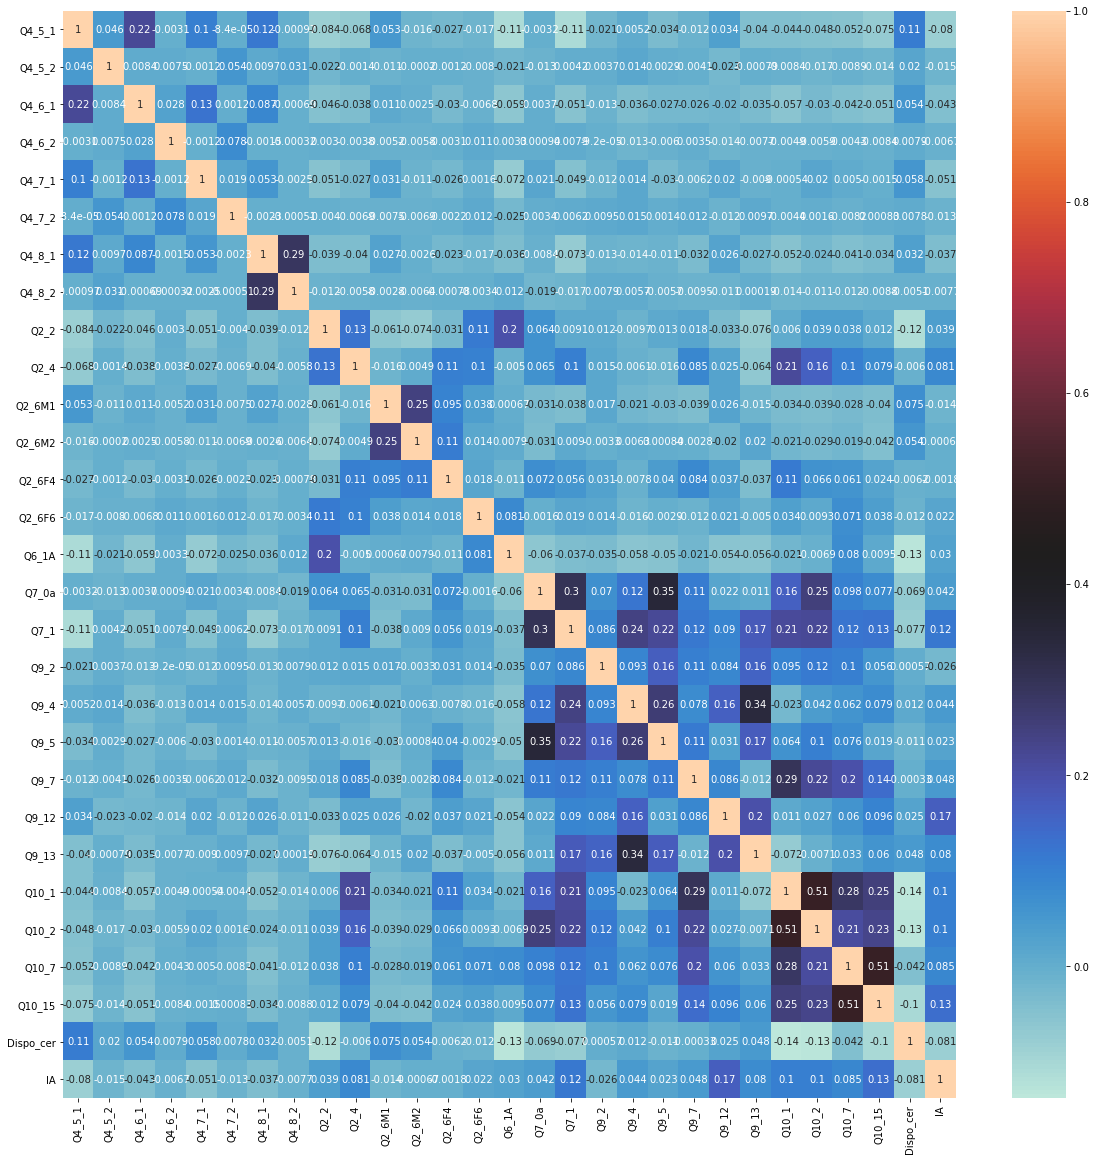

In [194]:
matrix = df_selected.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(matrix,annot=True, cmap="icefire")

*Features selection and modeling*

In [350]:
def roc_graph(fpr, tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def evaluation(model):
    model.fit(X_train,y_train)
    y_pred_train = model.predict_proba(X_train)[:,1]
    y_pred_test = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_train,(y_pred_train), pos_label=1)
    print("AUC on train set : ", auc(fpr, tpr))
    roc_graph(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_test,(y_pred_test), pos_label=1)
    print("AUC on test set : ", auc(fpr, tpr))
    roc_graph(fpr, tpr)
    print("*"*50)
    print(classification_report(y_test, y_pred))
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1,1,10,))
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')

In [351]:
X = df_selected.drop('IA', axis=1)
y = df_selected['IA']

In [352]:
ts = 0.25
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=ts,random_state=42,stratify=y)

In [353]:
y_test.mean()

0.2023370233702337

*test model: Random Forest*

In [354]:
from sklearn.ensemble import RandomForestClassifier

In [355]:
rfc = RandomForestClassifier(random_state=42)

AUC on train set :  0.9986092427900877


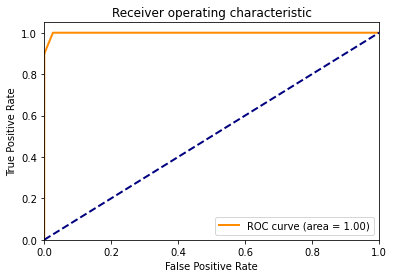

AUC on test set :  0.7594331553057909


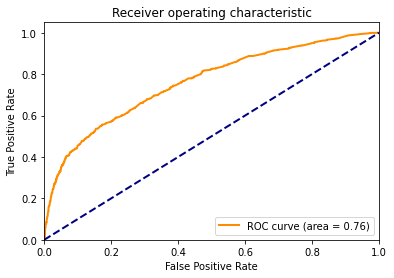

**************************************************
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      2594
           1       0.64      0.34      0.44       658

    accuracy                           0.83      3252
   macro avg       0.74      0.64      0.67      3252
weighted avg       0.81      0.83      0.81      3252



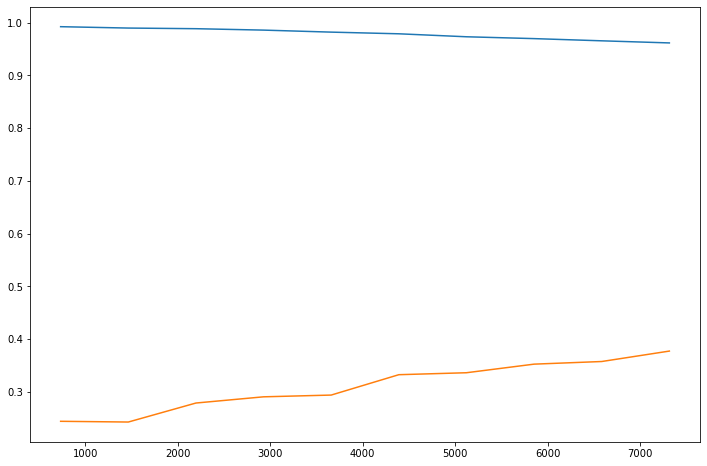

In [356]:
evaluation(rfc)

In [343]:
plt.figure(figsize=(20,20))
pd.DataFrame(rfc.feature_importances_, index=X.columns).plot.bar()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

<Figure size 1440x1440 with 0 Axes>

In [284]:
feature_thres = pd.DataFrame(rfc.feature_importances_, index=X.columns)
#feature_thres = feature_thres[feature_thres > 0.01].dropna()
test = feature_thres.index.to_list()

*test regression lineaire*

In [328]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [329]:
target = ['FCS']
df_selected = df[Q4 + Q2 + Q6 + Q7 + Q9 + Q10 + other + target]
df_modele.head()

Latitude  Longitude    Altitude      Accuracy  Q2_0c  Q2_0a  Q2_1  Q2_2  \
0  16.207429  -7.178067  284.147441  4.0000000000   10.0    1.0  55.0   1.0   
1  15.645690  -7.999437  326.647811  4.0000000000    4.0    1.0  67.0   2.0   
2  16.208374  -7.178670  283.850392  4.0000000000    2.0    1.0  40.0   1.0   
3  15.754509  -8.264417  260.409618  4.0000000000   15.0    1.0  38.0   2.0   
4  16.164117  -8.870325  217.179229  4.0000000000    5.0    0.0  45.0   1.0   

   Q2_3  Q2_4  ...  revenu2  revenu3  revenu_mens   rev_percap      DepNalim  \
0   1.0   6.0  ...     33.0      0.0         66.0     4.258065      0.000000   
1   3.0   6.0  ...      0.0      0.0       1000.0  1000.000000    833.333333   
2   1.0   5.0  ...      0.0      0.0       6000.0  1500.000000  24000.000000   
3   3.0   6.0  ...   2000.0      0.0       8000.0  2000.000000    166.666667   
4   1.0   6.0  ...   8000.0      0.0       8025.0  1146.428571  21833.333333   

   Depalim        Deptot   Pcdepalim  PcdepNalim  IA  
0  58600.0  58600.000000  100.000000    0.000000   0  
1   9000.0   9833.333333   91.525424    8.474576   0  
2  12600.0  36600.000000   34.426230   65.573770   1  
3  13600.0  13766.666667   98.789346    1.210654   1  
4  42500.0  64333.333333   66.062176   33.937824   0  

[5 rows x 151 columns]

In [330]:
df_selected.isna().sum()

Q4_5_1       0
Q4_6_1       0
Q4_7_1       0
Q4_8_1       0
Q2_2         0
Q2_4         0
Q2_6M1       0
Q2_6M2       0
Q2_6F4       0
Q2_6F6       0
Q6_1A        0
Q7_0a        0
Q7_1         0
Q9_2         0
Q9_4         0
Q9_5         0
Q9_7         0
Q9_12        0
Q9_13        0
Q10_1        0
Q10_2        0
Q10_3        0
Q10_4        0
Q10_5        0
Q10_7        0
Q10_8        0
Q10_9        0
Q10_10       0
Q10_11       0
Q10_12       0
Q10_13       0
Q10_14       0
Q10_15       0
Q10_16       0
Q10_17       0
Q10_18       0
Q10_19       0
Q10_20       0
Q10_21       0
Q10_22       0
Q10_23       0
Q10_24       1
Dispo_cer    0
FCS          2
dtype: int64

In [331]:
df_selected = df_selected.dropna().copy()

In [332]:
X = df_selected.drop("FCS", axis=1)
y = df_selected['FCS']

In [333]:
X = X.values

In [334]:
ts = 0.25
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=ts,random_state=42)

In [335]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [336]:
lr = LinearRegression()
lr.fit(X_train,y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [337]:
print("R2 score on training set : ", r2_score(y_train, y_train_pred))
print("R2 score on test set : ", r2_score(y_test, y_test_pred))

R2 score on training set :  0.21532311849337105
R2 score on test set :  0.1938546090120561


In [338]:
print("MAE score on training set : ", mean_absolute_error(y_train, y_train_pred))
print("MAE score on test set : ", mean_absolute_error(y_test, y_test_pred))

MAE score on training set :  13.945388000735104
MAE score on test set :  14.031358181216019


In [339]:
print("RMSE score on training set : ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("RMSE score on test set : ", np.sqrt(mean_squared_error(y_test, y_test_pred)))

RMSE score on training set :  17.29556151459392
RMSE score on test set :  17.58141644248279


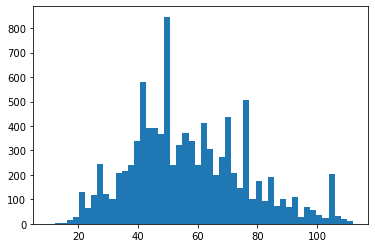

In [340]:
err_hist = np.abs(y_train, y_train_pred)
plt.hist(err_hist, bins=50)
plt.show()

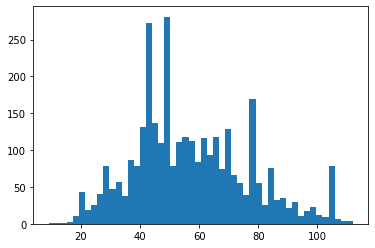

In [206]:
err_hist = np.abs(y_test, y_test_pred)
plt.hist(err_hist, bins=50)
plt.show()